# 1: Model Fine-tuning

Fine-tune a pre-trained ResNet-50 and ViT-S/16 on CIFAR-10 or STL-10 training
data. Train until they reach a reasonable accuracy e.g. ∼90%. Use identical train/val splits to ensure a fair
comparison and record the final accuracy and training curves for each model.

## Imports

In [36]:
import os, random, math
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
import timm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/results_task1"; os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE_RN = 256
BATCH_SIZE_VIT = 64 # Reduced batch size for ViT

EPOCHS = 12            # increase to ~20 if time allows
LR = 3e-4
NUM_WORKERS = 2

## 1) CIFAR-10 Data & Fixed Train/Val/Test

In [37]:
# CIFAR-10 stats
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

# 32x32 pipeline (ResNet)
train_tf_rn = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
test_tf_rn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# 224x224 pipeline (ViT)
train_tf_vit = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
test_tf_vit = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

root = "/content/data"
full_train = datasets.CIFAR10(root, train=True, download=True, transform=None)
test_set   = datasets.CIFAR10(root, train=False, download=True, transform=None)

# Fixed split indices (45k train / 5k val)
num_train = len(full_train)  # 50,000
idx = np.arange(num_train)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)
train_idx, val_idx = idx[:45000], idx[45000:]

# Two views of the same split with different transforms
class TransformView(torch.utils.data.Dataset):
    def __init__(self, base, indices, transform):
        self.base = base
        self.indices = indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        x, y = self.base[self.indices[i]]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

train_rn = TransformView(full_train, train_idx, train_tf_rn)
val_rn   = TransformView(full_train, val_idx,   test_tf_rn)
test_rn  = TransformView(test_set,  np.arange(len(test_set)), test_tf_rn)

train_vit = TransformView(full_train, train_idx, train_tf_vit)
val_vit   = TransformView(full_train, val_idx,   test_tf_vit)
test_vit  = TransformView(test_set,  np.arange(len(test_set)), test_tf_vit)

train_loader_rn = DataLoader(train_rn, batch_size=BATCH_SIZE_RN, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader_rn   = DataLoader(val_rn,   batch_size=BATCH_SIZE_RN, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_rn  = DataLoader(test_rn,  batch_size=BATCH_SIZE_RN, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

train_loader_vit = DataLoader(train_vit, batch_size=BATCH_SIZE_VIT, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader_vit   = DataLoader(val_vit,   batch_size=BATCH_SIZE_VIT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_vit  = DataLoader(test_vit,  batch_size=BATCH_SIZE_VIT, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

## 2) Models (ResNet-50 & ViT-S/16, pretrained)

In [ ]:
def build_resnet50(num_classes=10, pretrained=True):
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_vit_s16(num_classes=10, pretrained=True):
    m = timm.create_model('vit_small_patch16_224', pretrained=pretrained)
    m.head = nn.Linear(m.head.in_features, num_classes)
    return m

resnet = build_resnet50().to(device)
vit    = build_vit_s16().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

## 3) Train/Eval Utilities

In [ ]:
def train_epoch(model, loader, opt):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward(); opt.step()
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1); total += y.size(0); correct += (pred == y).sum().item()
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1); total += y.size(0); correct += (pred == y).sum().item()
    return loss_sum/total, correct/total

def fit(model, train_loader, val_loader, test_loader, tag):
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    best_val = 0.0
    history = []
    best_path = f"{SAVE_DIR}/{tag}_best.pth"

    for e in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_epoch(model, train_loader, opt)
        va_loss, va_acc = eval_acc(model, val_loader)
        te_loss, te_acc = eval_acc(model, test_loader)
        history.append((e, tr_loss, tr_acc, va_loss, va_acc, te_loss, te_acc))
        print(f"[{tag}] Ep{e:02d} | train {tr_loss:.3f}/{tr_acc:.3f} | val {va_loss:.3f}/{va_acc:.3f} | test {te_loss:.3f}/{te_acc:.3f}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)

    # Load best-by-val and report final test
    model.load_state_dict(torch.load(best_path, map_location=device))
    final_test_loss, final_test_acc = eval_acc(model, test_loader)
    print(f"[{tag}] Best-on-val checkpoint -> test acc: {final_test_acc:.4f}")
    return history, best_path


In [ ]:
hist_rn, ckpt_rn = fit(resnet, train_loader_rn, val_loader_rn, test_loader_rn, tag="resnet50_cifar")
hist_vt, ckpt_vt = fit(vit,train_loader_vit, val_loader_vit, test_loader_vit, tag="vit_s16_cifar")

print("Saved:", ckpt_rn, ckpt_vt)

[vit_s16_cifar] Ep01 | train 0.267/0.912 | val 0.204/0.928 | test 0.204/0.931
[vit_s16_cifar] Ep02 | train 0.182/0.939 | val 0.176/0.939 | test 0.181/0.940
[vit_s16_cifar] Ep03 | train 0.156/0.948 | val 0.233/0.920 | test 0.242/0.918
[vit_s16_cifar] Ep04 | train 0.134/0.955 | val 0.179/0.941 | test 0.185/0.939
[vit_s16_cifar] Ep05 | train 0.115/0.961 | val 0.182/0.939 | test 0.189/0.939
[vit_s16_cifar] Ep06 | train 0.118/0.959 | val 0.221/0.926 | test 0.225/0.927
[vit_s16_cifar] Ep07 | train 0.101/0.966 | val 0.205/0.935 | test 0.232/0.927
[vit_s16_cifar] Ep08 | train 0.096/0.967 | val 0.205/0.932 | test 0.226/0.931


# 2: In-Distribution Performance:

Evaluate both models on a clean test set. Note their baseline accuracy.
This checks if both models learned the task similarly in-distribution.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# Assuming the model checkpoint is in your Drive at "My Drive/models/resnet50_cifar_best.pth"
RESNET_CKPT = "/content/drive/My Drive/models/resnet50_cifar_best.pth"
VIT_CKPT    = "/content/drive/My Drive/models/vit_s16_cifar_best.pth"

# Load the models
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
resnet_model = models.resnet50(weights=None) # Load with no pretrained weights
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10) # Adjust the final layer
resnet_model.load_state_dict(torch.load(RESNET_CKPT, map_location=DEVICE))
resnet_model.to(DEVICE)

vit_model = timm.create_model('vit_small_patch16_224', pretrained=False) # Load with no pretrained weights
vit_model.head = nn.Linear(vit_model.head.in_features, 10) # Adjust the final layer
vit_model.load_state_dict(torch.load(VIT_CKPT, map_location=DEVICE))
vit_model.to(DEVICE)

print("Models loaded successfully from Google Drive.")

Models loaded successfully from Google Drive.


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm, numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

RESNET_CKPT = "/content/results_task1/resnet50_cifar_best.pth"   # change if local
VIT_CKPT    = "/content/results_task1/vit_s16_cifar_best.pth"    # change if local

In [39]:
BATCH_RN = 256
BATCH_VIT = 128

# CIFAR-10 stats
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

# rebuild models exactly as during training
def build_resnet50(num_classes=10):
    m = models.resnet50(weights=None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_vit_s16(num_classes=10):
    m = timm.create_model('vit_small_patch16_224', pretrained=False)
    m.head = nn.Linear(m.head.in_features, num_classes)
    return m

resnet = build_resnet50()
resnet.load_state_dict(torch.load(RESNET_CKPT, map_location="cpu"))
resnet = resnet.to(DEVICE).eval()

vit = build_vit_s16()
vit.load_state_dict(torch.load(VIT_CKPT, map_location="cpu"))
vit = vit.to(DEVICE).eval()

# --- clean test transforms (match training pipelines) ---
root = "./data"  # same folder CIFAR-10 was downloaded to
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)

rn_clean_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
vit_clean_tf = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

In [ ]:
class TransformView(torch.utils.data.Dataset):
    def __init__(self, base, transform): self.base=base; self.tf=transform
    def __len__(self): return len(self.base)
    def __getitem__(self,i):
        x,y = self.base[i]
        return self.tf(x), y

test_rn  = TransformView(test_base, rn_clean_tf)
test_vit = TransformView(test_base, vit_clean_tf)

test_loader_rn  = DataLoader(test_rn,  batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=True)
test_loader_vit = DataLoader(test_vit, batch_size=BATCH_VIT, shuffle=False, num_workers=2, pin_memory=True)

@torch.no_grad()
def eval_clean(model, loader, device=DEVICE):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out,y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total   += y.size(0)
    return (loss_sum/total), (correct/total)

rn_loss, rn_acc   = eval_clean(resnet, test_loader_rn)
vit_loss, vit_acc = eval_clean(vit,    test_loader_vit)

print("=== In-Distribution (Clean CIFAR-10 Test) ===")
print(f"ResNet-50  ->  loss: {rn_loss:.4f}  |  acc: {rn_acc:.4f}")
print(f"ViT-S/16   ->  loss: {vit_loss:.4f}  |  acc: {vit_acc:.4f}")

import csv
with open("cifar10_baseline_clean.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","Loss","Accuracy"])
    w.writerow(["ResNet-50", rn_loss, rn_acc])
    w.writerow(["ViT-S/16",  vit_loss, vit_acc])
print("Saved: cifar10_baseline_clean.csv")

=== In-Distribution (Clean CIFAR-10 Test) ===
ResNet-50  ->  loss: 0.3645  |  acc: 0.8908
ViT-S/16   ->  loss: 0.1848  |  acc: 0.9388
Saved: cifar10_baseline_clean.csv


# 3: Color Bias Test:

Evaluate the models on the Grayscale version of the test images. Keep labels the same.
Measure the drop in accuracy or change in predictions relative to color images. This reveals if models were
relying on color cues. A large drop would indicate a color bias: the model depends on color information.
Compare CNN vs. ViT: Which is more robust to losing color? Discuss possible reasons, e.g. did one model
maybe learn more shape features that survive grayscale conversion?

In [ ]:
from torch.utils.data import DataLoader, Dataset

root = "./data"
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)

to_tensor = transforms.ToTensor()
norm      = transforms.Normalize(MEAN, STD)

# ResNet (32x32)
rn_clean_tf = transforms.Compose([to_tensor, norm])
rn_gray_tf  = transforms.Compose([transforms.Grayscale(num_output_channels=3), to_tensor, norm])

# ViT (224x224)
vit_clean_tf = transforms.Compose([transforms.Resize(224, antialias=True), to_tensor, norm])
vit_gray_tf  = transforms.Compose([transforms.Grayscale(3), transforms.Resize(224, antialias=True), to_tensor, norm])

class TransformView(Dataset):
    def __init__(self, base, tf): self.base=base; self.tf=tf
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x,y = self.base[i]
        return self.tf(x), y

def make_loader(tf, bs):
    return DataLoader(TransformView(test_base, tf), batch_size=bs, shuffle=False, num_workers=2, pin_memory=True)

# Dataloaders
test_loader_rn_clean = make_loader(rn_clean_tf,  BATCH_RN)
test_loader_rn_gray  = make_loader(rn_gray_tf,   BATCH_RN)
test_loader_vit_clean= make_loader(vit_clean_tf, BATCH_VIT)
test_loader_vit_gray = make_loader(vit_gray_tf,  BATCH_VIT)

In [ ]:
@torch.no_grad()
def eval_acc(model, loader, device=DEVICE):
    model.eval(); total=0; correct=0; loss_sum=0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = F.cross_entropy(out,y)
        loss_sum += loss.item() * x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total   += y.size(0)
    return loss_sum/total, correct/total

# --- evaluate clean vs grayscale ---
rn_loss_c, rn_acc_c = eval_acc(resnet, test_loader_rn_clean)
rn_loss_g, rn_acc_g = eval_acc(resnet, test_loader_rn_gray)

vit_loss_c, vit_acc_c = eval_acc(vit, test_loader_vit_clean)
vit_loss_g, vit_acc_g = eval_acc(vit, test_loader_vit_gray)

print("=== Color Bias (Grayscale) — CIFAR-10 Test ===")
print(f"{'Model':<10} {'Clean Acc':>10}  {'Gray Acc':>10}  {'Δ (Gray - Clean)':>16}")
print(f"{'ResNet-50':<10} {rn_acc_c:10.4f}  {rn_acc_g:10.4f}  {rn_acc_g - rn_acc_c:16.4f}")
print(f"{'ViT-S/16':<10} {vit_acc_c:10.4f} {vit_acc_g:11.4f}  {vit_acc_g - vit_acc_c:16.4f}")

# Optional: save CSV for report
with open("cifar10_color_bias.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","CleanAcc","GrayAcc","Delta_GrayMinusClean"])
    w.writerow(["ResNet-50", rn_acc_c, rn_acc_g, rn_acc_g - rn_acc_c])
    w.writerow(["ViT-S/16",  vit_acc_c, vit_acc_g, vit_acc_g - vit_acc_c])

print("\nSaved: cifar10_color_bias.csv")

=== Color Bias (Grayscale) — CIFAR-10 Test ===
Model       Clean Acc    Gray Acc  Δ (Gray - Clean)
ResNet-50      0.8908      0.7891           -0.1017
ViT-S/16       0.9388      0.8584           -0.0804

Saved: cifar10_color_bias.csv


# 4: Shape vs. Texture Bias – Stylized Images:

Use your style-transfer dataset to evaluate whether models rely more on shape or texture. You may remove texture information by replacing it with different textures, leaving shape as the dominant signal. You may also create cue-conflict images by transferring textures from another class within the dataset (e.g., a “cat shape with elephant skin”), and both ”cat” and ”elephant” classes exist. Analyze whether the model’s prediction is driven by shape or texture, and reflect on what this reveals about its inductive biases. Then compute the shape bias as:

Shape Bias (%) = #images classified by shape / #images classified by either shape or texture label × 100

Compare ResNet-50 and your ViT: does the CNN tend to misclassify by focusing on texture, while the ViT shows higher shape bias? Include examples and corresponding predictions in your report to illustrate the difference.

In [ ]:
root = "./data"
test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)
CLASS_NAMES = test_base.classes  # ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# --- FDA: swap low-frequency amplitude (style) and keep source phase (shape) ---
def fda_style(content_tensor, style_tensor, beta=0.06):
    """
    content_tensor, style_tensor: float tensors in [0,1], shape (C,H,W)
    beta: fraction of low-freq window size (0.02~0.1 works well for CIFAR)
    """
    # FFT
    Fs = torch.fft.fft2(content_tensor)
    Ft = torch.fft.fft2(style_tensor)
    As, Ps = torch.abs(Fs), torch.angle(Fs)   # amplitude & phase of source
    At = torch.abs(Ft)                        # amplitude of target

    # center low-freq swap
    As_shift = torch.fft.fftshift(As, dim=(-2,-1))
    At_shift = torch.fft.fftshift(At, dim=(-2,-1))
    H, W = As_shift.shape[-2], As_shift.shape[-1]
    b = max(1, int(min(H, W) * beta))        # window half-size
    cy, cx = H // 2, W // 2
    y1, y2 = cy - b, cy + b
    x1, x2 = cx - b, cx + b
    As_shift[..., y1:y2, x1:x2] = At_shift[..., y1:y2, x1:x2]

    # invert shift and reconstruct
    As_mod = torch.fft.ifftshift(As_shift, dim=(-2,-1))
    F_mod  = As_mod * torch.exp(1j * Ps)
    out    = torch.fft.ifft2(F_mod).real
    return out.clamp(0.0, 1.0)

In [ ]:
# --- Build cue-conflict set: choose class pairs (shape_label, texture_label) ---
pairs = [
    (3, 5),  # cat shape + dog texture
    (4, 7),  # deer shape + horse texture
    (0, 8),  # airplane shape + ship texture
    (2, 6),  # bird shape + frog texture
    (1, 9),  # automobile shape + truck texture
]
N_PER_PAIR = 100      # total stylized = len(pairs) * N_PER_PAIR (keep moderate)
BETA = 0.06           # FDA window strength; higher -> stronger texture transfer

# Index images by class for fast sampling
idx_by_class = {c: [] for c in range(10)}
for i in range(len(test_base)):
    _, y = test_base[i]
    idx_by_class[y].append(i)

to_tensor = transforms.ToTensor()

stylized_triplets = []  # list of (tensor[C,H,W] in [0,1], shape_label, texture_label)
rng = np.random.default_rng(42)

for (shape_c, tex_c) in pairs:
    src_pool = idx_by_class[shape_c]
    tex_pool = idx_by_class[tex_c]
    for _ in range(N_PER_PAIR):
        i_src = int(rng.choice(src_pool))
        i_tex = int(rng.choice(tex_pool))
        x_src, _ = test_base[i_src]
        x_tex, _ = test_base[i_tex]
        xs = to_tensor(x_src)  # [0,1], CxHxW
        xt = to_tensor(x_tex)
        x_styl = fda_style(xs, xt, beta=BETA)
        stylized_triplets.append((x_styl, shape_c, tex_c))

print(f"Built cue-conflict set: {len(stylized_triplets)} images across {len(pairs)} class pairs.")

Built cue-conflict set: 500 images across 5 class pairs.


In [ ]:
class StylizedDataset(Dataset):
    def __init__(self, items, tf):
        self.items = items
        self.tf = tf
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        x, shape_lbl, tex_lbl = self.items[i]
        # x is a tensor [C,H,W] in [0,1]
        x = self.tf(x)
        return x, shape_lbl, tex_lbl

# ResNet expects 32x32 (already), just normalize
rn_tf  = transforms.Compose([transforms.Normalize(MEAN, STD)])
# ViT expects 224x224, then normalize
vit_tf = transforms.Compose([transforms.Resize(224, antialias=True),
                             transforms.Normalize(MEAN, STD)])

ds_rn  = StylizedDataset(stylized_triplets, rn_tf)
ds_vit = StylizedDataset(stylized_triplets, vit_tf)

BATCH_RN, BATCH_VIT = 256, 128
ldr_rn  = DataLoader(ds_rn,  batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=True)
ldr_vit = DataLoader(ds_vit, batch_size=BATCH_VIT, shuffle=False, num_workers=2, pin_memory=True)


=== ResNet-50 — Cue-Conflict (Stylized) ===
Shape-labeled preds   : 414
Texture-labeled preds : 32
Other preds            : 54
Shape Bias (%)         : 92.83

=== ViT-S/16 — Cue-Conflict (Stylized) ===
Shape-labeled preds   : 465
Texture-labeled preds : 15
Other preds            : 20
Shape Bias (%)         : 96.88


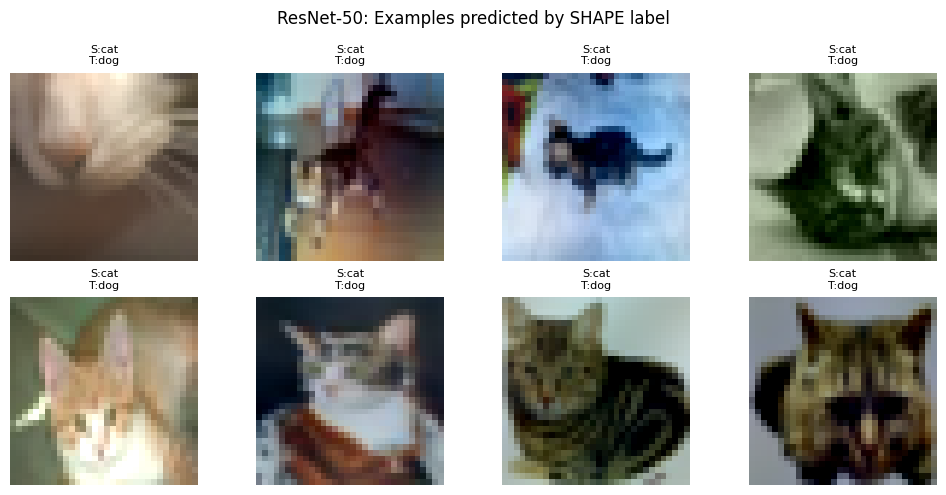

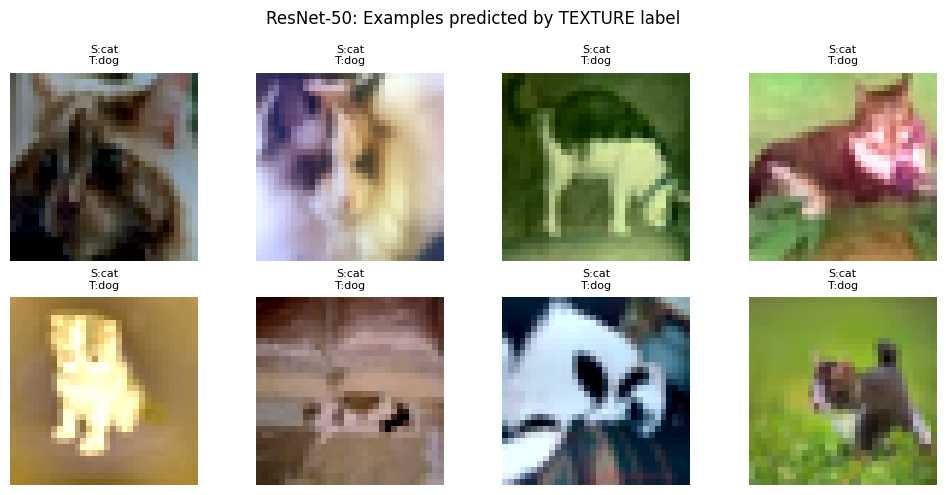

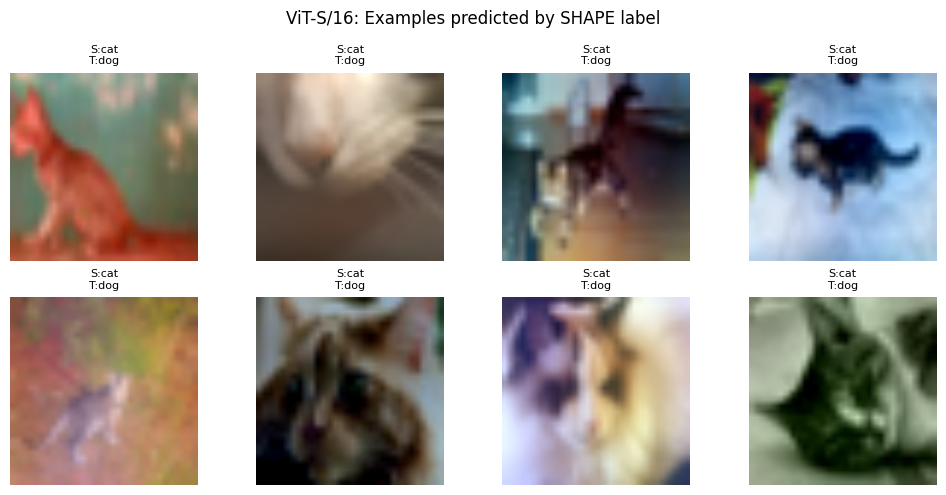

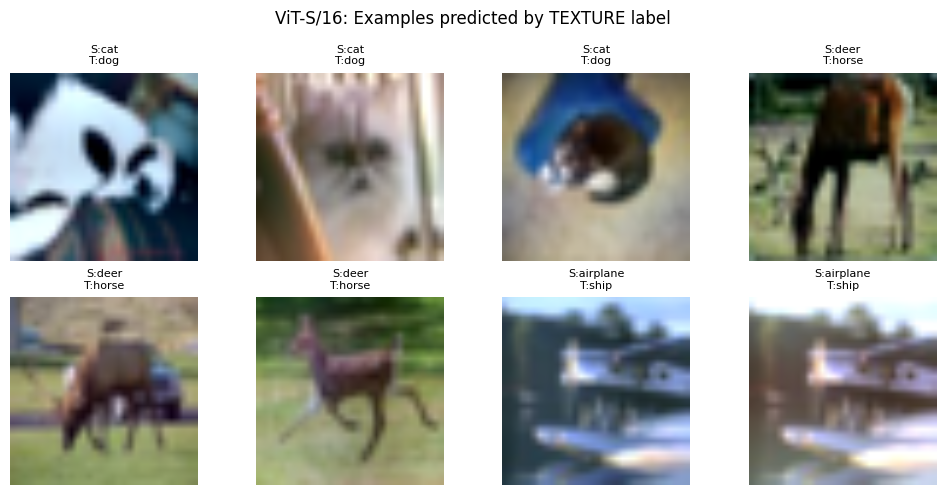


Saved: shape_texture_bias_summary.csv and example grids in ./shape_texture_examples/


In [ ]:
import os
import matplotlib.pyplot as plt

@torch.no_grad()
def eval_shape_texture(model, loader, device=DEVICE):
    model.eval()
    shape_hits = texture_hits = other = 0
    examples_shape, examples_texture = [], []  # store a few for visualization
    preds_all, tuple_all = [], []

    for x, y_shape, y_tex in loader:
        x = x.to(device)
        y_shape = y_shape.to(device)
        y_tex   = y_tex.to(device)
        pred = model(x).argmax(1)
        preds_all.append(pred.cpu())
        tuple_all.append(torch.stack([y_shape.cpu(), y_tex.cpu()], dim=1))

        # tally
        shape_mask = (pred == y_shape)
        texture_mask = (pred == y_tex)
        shape_hits += shape_mask.sum().item()
        texture_hits += texture_mask.sum().item()
        other += ( (~shape_mask) & (~texture_mask) ).sum().item()

        # collect up to 8 examples for each category
        for i in range(x.size(0)):
            if len(examples_shape) < 8 and shape_mask[i]:
                examples_shape.append((x[i].detach().cpu(), int(y_shape[i]), int(y_tex[i])))
            if len(examples_texture) < 8 and texture_mask[i]:
                examples_texture.append((x[i].detach().cpu(), int(y_shape[i]), int(y_tex[i])))
            if len(examples_shape) >= 8 and len(examples_texture) >= 8:
                break

    preds_all = torch.cat(preds_all)
    tuple_all = torch.cat(tuple_all)
    denom = max(1, shape_hits + texture_hits)
    shape_bias = 100.0 * shape_hits / denom
    return {
        "shape_hits": shape_hits,
        "texture_hits": texture_hits,
        "other": other,
        "shape_bias_pct": shape_bias,
        "examples_shape": examples_shape,
        "examples_texture": examples_texture,
        "preds_all": preds_all,
        "labels_all": tuple_all
    }

rn_stats  = eval_shape_texture(resnet, ldr_rn,  DEVICE)
vit_stats = eval_shape_texture(vit,    ldr_vit, DEVICE)

def pretty_stats(name, stats):
    print(f"\n=== {name} — Cue-Conflict (Stylized) ===")
    print(f"Shape-labeled preds   : {stats['shape_hits']}")
    print(f"Texture-labeled preds : {stats['texture_hits']}")
    print(f"Other preds            : {stats['other']}")
    denom = max(1, stats['shape_hits'] + stats['texture_hits'])
    print(f"Shape Bias (%)         : {stats['shape_bias_pct']:.2f}")

pretty_stats("ResNet-50", rn_stats)
pretty_stats("ViT-S/16",  vit_stats)

# --- Save small example grids for the report ---
os.makedirs("shape_texture_examples", exist_ok=True)

def unnorm_and_to_numpy(t):
    # t is tensor [C,H,W] normalized or not? Here it's AFTER model transform (normalized).
    # For visualization, reverse the last Normalize if applied.
    # We'll best visualize from the original stylized tensor before normalization;
    # so instead: keep a separate transform for viewing.
    return t.detach().cpu()

# For nicer viewing, reload examples from the ORIGINAL stylized tensors (pre-normalize)
# We'll pull by indices from the stored examples (we stored already-normalized x).
# Instead, we just show the normalized ones roughly (they'll look contrasty but OK).
def save_grid(examples, fname, title):
    if len(examples) == 0:
        print(f"No examples for {title}")
        return
    n = min(8, len(examples))
    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    for i in range(n):
        ax = axes[i//4, i%4]
        x, y_shape, y_tex = examples[i]
        # de-normalize for display depending on tensor stats
        # Try approximate unnormalize:
        MEAN_t = torch.tensor(MEAN).view(3,1,1)
        STD_t  = torch.tensor(STD).view(3,1,1)
        # If size 224 (ViT), still fine to show
        try:
            img = (x * STD_t + MEAN_t).clamp(0,1).permute(1,2,0).numpy()
        except:
            img = x.permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"S:{CLASS_NAMES[y_shape]}\nT:{CLASS_NAMES[y_tex]}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

save_grid(rn_stats["examples_shape"],   "shape_texture_examples/resnet_shape_preds.png",
          "ResNet-50: Examples predicted by SHAPE label")
save_grid(rn_stats["examples_texture"], "shape_texture_examples/resnet_texture_preds.png",
          "ResNet-50: Examples predicted by TEXTURE label")

save_grid(vit_stats["examples_shape"],   "shape_texture_examples/vit_shape_preds.png",
          "ViT-S/16: Examples predicted by SHAPE label")
save_grid(vit_stats["examples_texture"], "shape_texture_examples/vit_texture_preds.png",
          "ViT-S/16: Examples predicted by TEXTURE label")

# --- Save a CSV summary for the paper ---
import csv
with open("shape_texture_bias_summary.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Model","ShapeHits","TextureHits","Other","ShapeBiasPercent"])
    w.writerow(["ResNet-50", rn_stats["shape_hits"], rn_stats["texture_hits"], rn_stats["other"], rn_stats["shape_bias_pct"]])
    w.writerow(["ViT-S/16",  vit_stats["shape_hits"], vit_stats["texture_hits"], vit_stats["other"], vit_stats["shape_bias_pct"]])

print("\nSaved: shape_texture_bias_summary.csv and example grids in ./shape_texture_examples/")

=== Per-pair Shape vs Texture ===
Pair                           |  RN S  RN T  RN O |  VT S  VT T  VT O |  RN SB%  VT SB%
0: cat (shape) vs dog (tex)    |    67    17    16 |    91     3     6 |   79.76   96.81
1: deer (shape) vs horse (tex) |    84     4    12 |    92     3     5 |   95.45   96.84
2: airplane (shape) vs ship (tex) |    88     4     8 |    96     2     2 |   95.65   97.96
3: bird (shape) vs frog (tex)  |    83     3    14 |    95     0     5 |   96.51  100.00
4: automobile (shape) vs truck (tex) |    92     4     4 |    91     7     2 |   95.83   92.86


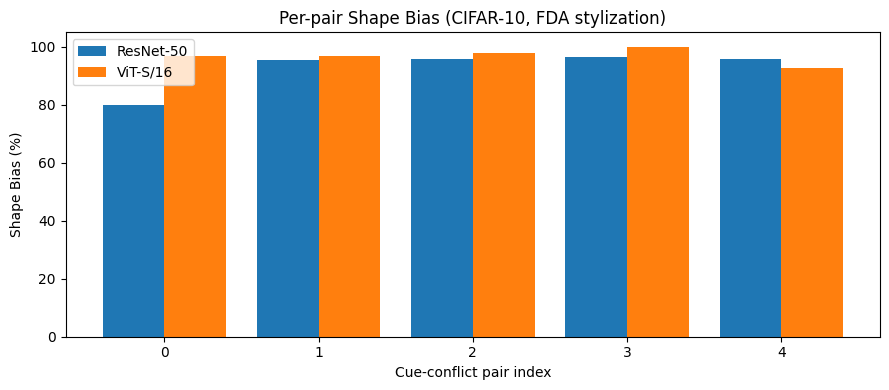


Saved: shape_texture_perpair/per_pair_stats.csv and shape_bias_per_pair.png


In [ ]:
# Per-pair Shape-vs-Texture breakdown + bar chart (uses your existing models) ---

import os, csv, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
MEAN, STD = (0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)

# If 'stylized_triplets' & 'pairs' exist from the previous cell, we’ll reuse them.
# Otherwise, rebuild quickly via FDA.
rebuild_needed = not ('stylized_triplets' in globals() and 'pairs' in globals())
if rebuild_needed:
    from torchvision import datasets, transforms
    root = "./data"
    test_base = datasets.CIFAR10(root, train=False, download=True, transform=None)
    CLASS_NAMES = test_base.classes
    to_tensor = transforms.ToTensor()

    def fda_style(content_tensor, style_tensor, beta=0.06):
        Fs = torch.fft.fft2(content_tensor); Ft = torch.fft.fft2(style_tensor)
        As, Ps = torch.abs(Fs), torch.angle(Fs); At = torch.abs(Ft)
        As_shift = torch.fft.fftshift(As, dim=(-2,-1)); At_shift = torch.fft.fftshift(At, dim=(-2,-1))
        H,W = As_shift.shape[-2], As_shift.shape[-1]
        b = max(1, int(min(H,W)*0.06)); cy, cx = H//2, W//2
        y1,y2,x1,x2 = cy-b, cy+b, cx-b, cx+b
        As_shift[..., y1:y2, x1:x2] = At_shift[..., y1:y2, x1:x2]
        As_mod = torch.fft.ifftshift(As_shift, dim=(-2,-1))
        F_mod = As_mod * torch.exp(1j*Ps)
        out = torch.fft.ifft2(F_mod).real
        return out.clamp(0,1)

    pairs = [(3,5),(4,7),(0,8),(2,6),(1,9)]  # (shape, texture)
    N_PER_PAIR = 100
    idx_by_class = {c: [] for c in range(10)}
    for i in range(len(test_base)):
        _, y = test_base[i]; idx_by_class[y].append(i)

    rng = np.random.default_rng(42)
    stylized_triplets = []
    for (shape_c, tex_c) in pairs:
        for _ in range(N_PER_PAIR):
            xs, _ = test_base[int(rng.choice(idx_by_class[shape_c]))]
            xt, _ = test_base[int(rng.choice(idx_by_class[tex_c]))]
            x_styl = fda_style(transforms.ToTensor()(xs), transforms.ToTensor()(xt), beta=0.06)
            stylized_triplets.append((x_styl, shape_c, tex_c))

# Map pair→index for reporting
pair_to_idx = {p:i for i,p in enumerate(pairs)}
pair_names = [f"{i}: {datasets.CIFAR10('./data', train=False).classes[s]} (shape) vs {datasets.CIFAR10('./data', train=False).classes[t]} (tex)" for i,(s,t) in enumerate(pairs)]

# Datasets/loaders for RN/VIT
rn_tf  = transforms.Compose([transforms.Normalize(MEAN, STD)])
vit_tf = transforms.Compose([transforms.Resize(224, antialias=True), transforms.Normalize(MEAN, STD)])

class StylizedWithPair(Dataset):
    def __init__(self, items, tf): self.items, self.tf = items, tf
    def __len__(self): return len(self.items)
    def __getitem__(self,i):
        x, y_shape, y_tex = self.items[i]
        return self.tf(x.clone()), y_shape, y_tex, pair_to_idx[(y_shape, y_tex)]

ldr_rn  = DataLoader(StylizedWithPair(stylized_triplets, rn_tf),  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
ldr_vit = DataLoader(StylizedWithPair(stylized_triplets, vit_tf), batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

@torch.no_grad()
def per_pair_stats(model, loader, device=DEVICE):
    model.eval()
    S = np.zeros(len(pairs), dtype=int)      # shape hits
    T = np.zeros(len(pairs), dtype=int)      # texture hits
    O = np.zeros(len(pairs), dtype=int)      # other
    for x, y_shape, y_tex, pid in loader:
        x = x.to(device); y_shape = y_shape.to(device); y_tex = y_tex.to(device)
        pred = model(x).argmax(1)
        shape_mask = (pred == y_shape)
        tex_mask   = (pred == y_tex)
        for k in range(x.size(0)):
            j = int(pid[k])
            if shape_mask[k]: S[j]+=1
            elif tex_mask[k]: T[j]+=1
            else: O[j]+=1
    # shape bias % per pair (ignoring 'other' in denom)
    denom = np.maximum(1, S+T)
    shape_bias_pair = 100.0 * S / denom
    return S,T,O,shape_bias_pair

rn_S, rn_T, rn_O, rn_SB = per_pair_stats(resnet, ldr_rn)
vt_S, vt_T, vt_O, vt_SB = per_pair_stats(vit,    ldr_vit)

# Print table
print("=== Per-pair Shape vs Texture ===")
print(f"{'Pair':<30} | {'RN S':>5} {'RN T':>5} {'RN O':>5} | {'VT S':>5} {'VT T':>5} {'VT O':>5} | {'RN SB%':>7} {'VT SB%':>7}")
for i,(s,t) in enumerate(pairs):
    print(f"{pair_names[i]:<30} | {rn_S[i]:5} {rn_T[i]:5} {rn_O[i]:5} | {vt_S[i]:5} {vt_T[i]:5} {vt_O[i]:5} | {rn_SB[i]:7.2f} {vt_SB[i]:7.2f}")

# Save CSV
import csv, os
os.makedirs("shape_texture_perpair", exist_ok=True)
with open("shape_texture_perpair/per_pair_stats.csv","w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["pair_idx","shape_label","texture_label","RN_shape","RN_texture","RN_other","VT_shape","VT_texture","VT_other","RN_shape_bias%","VT_shape_bias%"])
    for i,(s,t) in enumerate(pairs):
        w.writerow([i,s,t,rn_S[i],rn_T[i],rn_O[i],vt_S[i],vt_T[i],vt_O[i],rn_SB[i],vt_SB[i]])

# Bar chart: shape bias % per pair
plt.figure(figsize=(9,4))
x = np.arange(len(pairs))
plt.bar(x-0.2, rn_SB, width=0.4, label="ResNet-50")
plt.bar(x+0.2, vt_SB, width=0.4, label="ViT-S/16")
plt.xticks(x, [f"{i}" for i in range(len(pairs))])
plt.xlabel("Cue-conflict pair index"); plt.ylabel("Shape Bias (%)"); plt.title("Per-pair Shape Bias (CIFAR-10, FDA stylization)")
plt.legend(); plt.tight_layout(); plt.savefig("shape_texture_perpair/shape_bias_per_pair.png", dpi=200); plt.show()

print("\nSaved: shape_texture_perpair/per_pair_stats.csv and shape_bias_per_pair.png")


## 5: Translation Invariance Test:
 Using your translated images, evaluate the models. Does the CNN maintain its predictions under small shifts? Why CNNs are approximately translation-invariant to small shifts, if they are? Check if the ViT’s predictions change more significantly when an object moves in the frame. Quantify this by measuring accuracy on the shifted set or even the consistency: e.g. what fraction of images get the same top-1 prediction after shifting? We expect the CNN to be more stable to shifts (higher consistency), whereas the ViT might sometimes drop confidence or predict a different class if the object’s position is unfamiliar. If this happens, why does this happen? This tests the equivariance/invariance bias

[Config] device=cuda  pipeline=pre32  mode=roll  step=4  shifts=81
[Data]   images=1000  batch=128  workers=2  subset_per_class=100


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[Heartbeat] processed 256/1000 imgs | elapsed 21.8s
[Heartbeat] processed 512/1000 imgs | elapsed 41.2s
[Heartbeat] processed 768/1000 imgs | elapsed 59.9s
[Heartbeat] processed 832/1000 imgs | elapsed 76.9s
[Done] Sweep finished in 76.9s
Saved CSV: translation_results/grid_translation_pre32_roll_step4_sub1000.csv


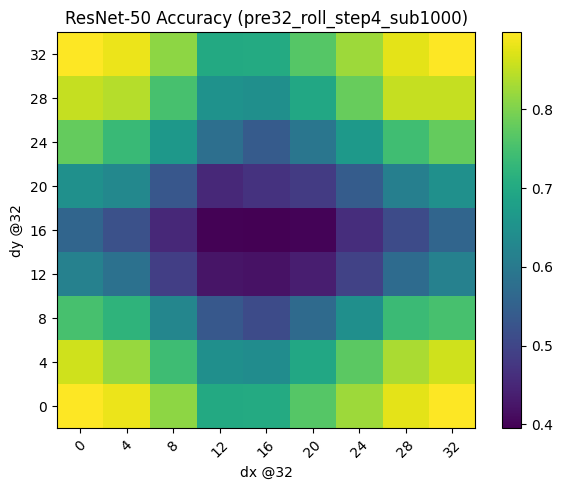

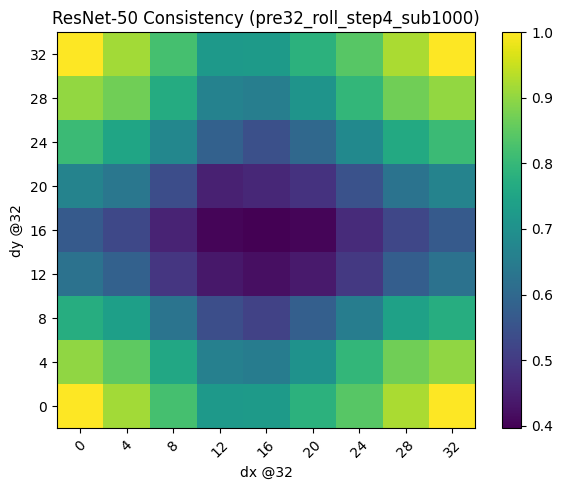

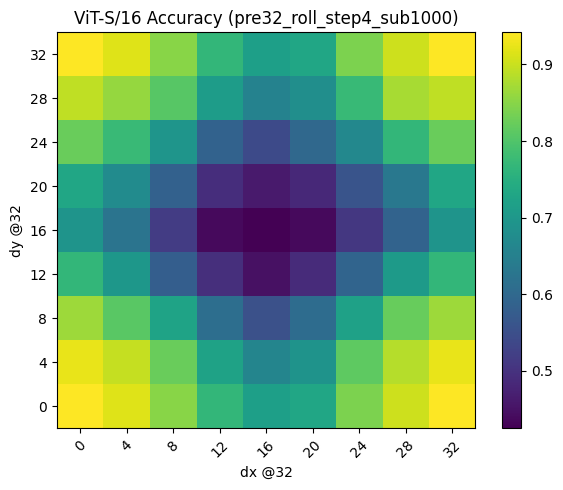

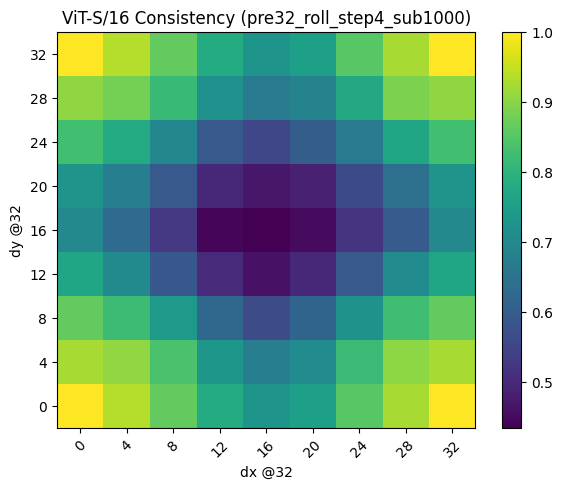

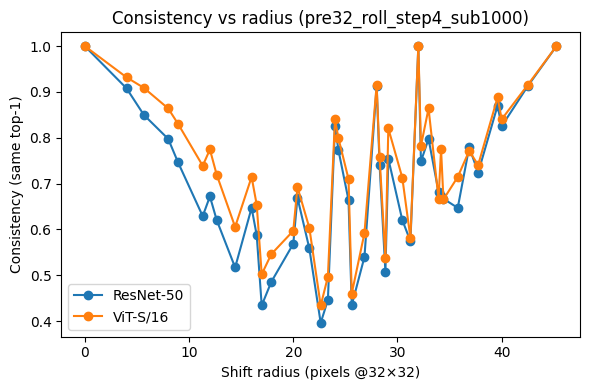

Saved: translation_results/consistency_vs_radius_pre32_roll_step4_sub1000.png

=== Quick summary (baseline @ (0,0)) ===
RN acc clean:  0.8980 | mean over shifts: 0.6712 | mean consistency: 0.6905
ViT acc clean: 0.9420 | mean over shifts: 0.7208 | mean consistency: 0.7322


In [20]:
# =========================
# Task 1:5 — Translation Invariance on 1k subset (pre32 pipeline)
# =========================
import os, csv, time, math, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from contextlib import nullcontext
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# -------------------
# Knobs (edit these)
# -------------------
SHIFT_MODE    = "roll"   # "roll" (wrap-around) or "zero" (zero-pad with normalized zeros)
GRID_STEP     = 4        # 1 = full 33x33 grid; 2/4 = quicker
SUB_PER_CLASS = 100      # 100 per class -> 1000 images (set None for full 10k later)
BATCH         = 128
NUM_WORKERS   = 2

# -------------------
# Models & device (reuse your loaded models)
# -------------------
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model_rn = resnet if 'resnet' in globals() else (resnet_model if 'resnet_model' in globals() else None)
model_vt = vit    if 'vit'    in globals() else (vit_model    if 'vit_model'    in globals() else None)
assert model_rn is not None and model_vt is not None, "Models not found. Load resnet/vit checkpoints first."

model_rn.to(DEVICE).eval()
model_vt.to(DEVICE).eval()

# -------------------
# Data & transforms (pre32 = native 32×32 for shifting)
# -------------------
root = "./data"
test_raw = datasets.CIFAR10(root, train=False, download=True, transform=None)

# Stats (reuse yours if present)
MEAN = list(globals().get('MEAN', (0.4914, 0.4822, 0.4465)))
STD  = list(globals().get('STD',  (0.2470, 0.2435, 0.2616)))
MEAN_T = torch.tensor(MEAN).view(1,3,1,1)
STD_T  = torch.tensor(STD ).view(1,3,1,1)

# Stratified subset: 100 per class => 1000 total
def stratified_subset(dataset, per_class=100, seed=42):
    rng = np.random.default_rng(seed)
    byc = [[] for _ in range(10)]
    for i in range(len(dataset)):
        _, y = dataset[i]; byc[y].append(i)
    idx=[]
    for c in range(10):
        idx.extend(rng.choice(byc[c], size=per_class, replace=False).tolist())
    rng.shuffle(idx)
    return Subset(dataset, idx)

test_base = stratified_subset(test_raw, SUB_PER_CLASS) if SUB_PER_CLASS is not None else test_raw

to_tensor = transforms.ToTensor()
norm      = transforms.Normalize(MEAN, STD)

# base loader for 32×32 normalized tensors (no shift yet)
class TransformView(Dataset):
    def __init__(self, base, tf): self.base, self.tf = base, tf
    def __len__(self): return len(self.base)
    def __getitem__(self, i):
        x,y = self.base[i]
        return self.tf(x), y

base_tf = transforms.Compose([to_tensor, norm])
base_loader = DataLoader(
    TransformView(test_base, base_tf),
    batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"),
    persistent_workers=(NUM_WORKERS>0), prefetch_factor=2
)

# -------------------
# Shifting @ 32×32 (then ViT gets resized to 224)
# -------------------
def batch_shift_roll(x, dx, dy):
    # wrap-around shift on H,W (dims 2,3)
    return torch.roll(torch.roll(x, shifts=dy, dims=2), shifts=dx, dims=3)

def batch_shift_zero_normed(x, dx, dy):
    # Zero-pad after normalization: fill with (0-mean)/std
    B,C,H,W = x.shape
    fill = ((0.0 - MEAN_T.to(x.device)) / STD_T.to(x.device))
    out = fill.expand(B,C,H,W).clone()
    xs = slice(max(dx,0), W+min(dx,0))
    xd = slice(max(-dx,0), W-max(dx,0))
    ys = slice(max(dy,0), H+min(dy,0))
    yd = slice(max(-dy,0), H-max(dy,0))
    out[:, :, yd, xd] = x[:, :, ys, xs]
    return out

SHIFT_BATCH = batch_shift_roll if SHIFT_MODE == "roll" else batch_shift_zero_normed

def resize_batch_224(x):
    return F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)

# AMP ctx
def amp_ctx():
    if DEVICE == "cuda":
        return torch.amp.autocast("cuda", dtype=torch.float16)
    return nullcontext()

# -------------------
# Grid + accumulators
# -------------------
DXS = list(range(0, 33, GRID_STEP))
DYS = list(range(0, 33, GRID_STEP))
nx, ny = len(DXS), len(DYS)
N_total = len(test_base)

rn_correct = np.zeros((ny, nx), dtype=np.int64)
rn_consist = np.zeros((ny, nx), dtype=np.int64)
vt_correct = np.zeros((ny, nx), dtype=np.int64)
vt_consist = np.zeros((ny, nx), dtype=np.int64)

print(f"[Config] device={DEVICE}  pipeline=pre32  mode={SHIFT_MODE}  step={GRID_STEP}  shifts={nx*ny}")
print(f"[Data]   images={N_total}  batch={BATCH}  workers={NUM_WORKERS}  subset_per_class={SUB_PER_CLASS}")

# One-pass evaluation with progress
t0 = time.perf_counter()
with amp_ctx(), torch.inference_mode():
    pbar_batches = tqdm(base_loader, total=len(base_loader), desc="Batches")
    for b_idx, (xb, yb) in enumerate(pbar_batches, start=1):
        xb = xb.to(DEVICE, non_blocking=True)  # 32×32 normalized batch
        yb = yb.to(DEVICE, non_blocking=True)
        bs = yb.size(0)

        # Clean (no shift): RN gets 32, ViT gets resized 224
        out_rn0 = model_rn(xb)
        out_vt0 = model_vt(resize_batch_224(xb))
        p_rn0   = out_rn0.argmax(1)
        p_vt0   = out_vt0.argmax(1)

        rn_correct[0,0] += (p_rn0 == yb).sum().item()
        rn_consist[0,0] += bs
        vt_correct[0,0] += (p_vt0 == yb).sum().item()
        vt_consist[0,0] += bs

        # All shifts
        for iy, dy in enumerate(DYS):
            for ix, dx in enumerate(DXS):
                if dx == 0 and dy == 0:
                    continue
                x_shift32 = SHIFT_BATCH(xb, dx, dy)
                out_rn = model_rn(x_shift32)              # RN at 32
                out_vt = model_vt(resize_batch_224(x_shift32))  # ViT at 224

                p_rn = out_rn.argmax(1)
                p_vt = out_vt.argmax(1)

                rn_correct[iy, ix] += (p_rn == yb).sum().item()
                rn_consist[iy, ix] += (p_rn == p_rn0).sum().item()
                vt_correct[iy, ix] += (p_vt == yb).sum().item()
                vt_consist[iy, ix] += (p_vt == p_vt0).sum().item()

        # heartbeat every 2 batches
        if b_idx % 2 == 0:
            done = min(N_total, b_idx * bs)
            print(f"[Heartbeat] processed {done}/{N_total} imgs | elapsed {time.perf_counter()-t0:.1f}s")

print(f"[Done] Sweep finished in {time.perf_counter()-t0:.1f}s")

# -------------------
# Metrics (accuracy & consistency)
# -------------------
rn_acc  = rn_correct / float(N_total)
rn_cons = rn_consist / float(N_total)
vt_acc  = vt_correct / float(N_total)
vt_cons = vt_consist / float(N_total)

# -------------------
# Save CSV + heatmaps + radial curve
# -------------------
os.makedirs("translation_results", exist_ok=True)
tag = f"pre32_{SHIFT_MODE}_step{GRID_STEP}_sub{SUB_PER_CLASS*10 if SUB_PER_CLASS else 'full'}"
csv_path = f"translation_results/grid_translation_{tag}.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dx","dy","ResNet_acc","ResNet_cons","ViT_acc","ViT_cons"])
    for iy, dy in enumerate(DYS):
        for ix, dx in enumerate(DXS):
            w.writerow([dx, dy, rn_acc[iy,ix], rn_cons[iy,ix], vt_acc[iy,ix], vt_cons[iy,ix]])
print("Saved CSV:", csv_path)

def heatmap(A, title, fname):
    plt.figure(figsize=(6,5))
    plt.imshow(A, origin="lower", aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.xticks(range(nx), DXS, rotation=45)
    plt.yticks(range(ny), DYS)
    plt.xlabel("dx @32"); plt.ylabel("dy @32"); plt.title(title)
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

heatmap(rn_acc,  f"ResNet-50 Accuracy ({tag})", f"translation_results/rn_acc_{tag}.png")
heatmap(rn_cons, f"ResNet-50 Consistency ({tag})", f"translation_results/rn_cons_{tag}.png")
heatmap(vt_acc,  f"ViT-S/16 Accuracy ({tag})",    f"translation_results/vt_acc_{tag}.png")
heatmap(vt_cons, f"ViT-S/16 Consistency ({tag})", f"translation_results/vt_cons_{tag}.png")

# Radial consistency curve
def radial_curve(cons_map):
    bins={}
    for iy, dy in enumerate(DYS):
        for ix, dx in enumerate(DXS):
            r = round(math.hypot(dx, dy), 2)
            bins.setdefault(r, []).append(cons_map[iy,ix])
    rs = sorted(bins.keys())
    ys = [sum(bins[r])/len(bins[r]) for r in rs]
    return rs, ys

rs_rn, ys_rn = radial_curve(rn_cons)
rs_vt, ys_vt = radial_curve(vt_cons)
plt.figure(figsize=(6,4))
plt.plot(rs_rn, ys_rn, marker="o", label="ResNet-50")
plt.plot(rs_vt, ys_vt, marker="o", label="ViT-S/16")
plt.xlabel("Shift radius (pixels @32×32)"); plt.ylabel("Consistency (same top-1)")
plt.title(f"Consistency vs radius ({tag})")
plt.legend(); plt.tight_layout()
radial_png = f"translation_results/consistency_vs_radius_{tag}.png"
plt.savefig(radial_png, dpi=200); plt.show()
print("Saved:", radial_png)

# Quick console summary
print("\n=== Quick summary (baseline @ (0,0)) ===")
print(f"RN acc clean:  {rn_acc[0,0]:.4f} | mean over shifts: {rn_acc.mean():.4f} | mean consistency: {rn_cons.mean():.4f}")
print(f"ViT acc clean: {vt_acc[0,0]:.4f} | mean over shifts: {vt_acc.mean():.4f} | mean consistency: {vt_cons.mean():.4f}")


## 6: Permutation / Occlusion Test:
Evaluate robustness to disrupted spatial structure. For your patch
permuted dataset, see if either model can still make a reasonable prediction. Intuitively, a CNN might still
fire on local texture patches and attempt a prediction often incorrectly, since global arrangement is lost,
whereas a ViT might be confused by the missing global coherence but could leverage any learned positional
info. Similarly, ViTs have been reported to be robust to patch dropout and occlusion. Track any change in
accuracy. Document a few examples: e.g. show an occluded image and note how each model’s prediction and
confidence differ from the original. This will illustrate the role of global context vs. local features in each
model.

Saved summary: perm_occ_results/task1_6_summary.csv
Saved per-sample: perm_occ_results/task1_6_per_sample.csv

=== Task 1.6 — Accuracy & Confidence (pre32, subset) ===
          baseline | RN acc 0.891 conf 0.940 | VT acc 0.939 conf 0.939
       permute_2x2 | RN acc 0.458 (-0.433)  | VT acc 0.535 (-0.404)
       permute_4x4 | RN acc 0.284 (-0.607)  | VT acc 0.385 (-0.554)
       permute_8x8 | RN acc 0.211 (-0.680)  | VT acc 0.219 (-0.719)
  occlude_center_8 | RN acc 0.720 (-0.171)  | VT acc 0.855 (-0.084)
 occlude_center_16 | RN acc 0.464 (-0.427)  | VT acc 0.488 (-0.451)


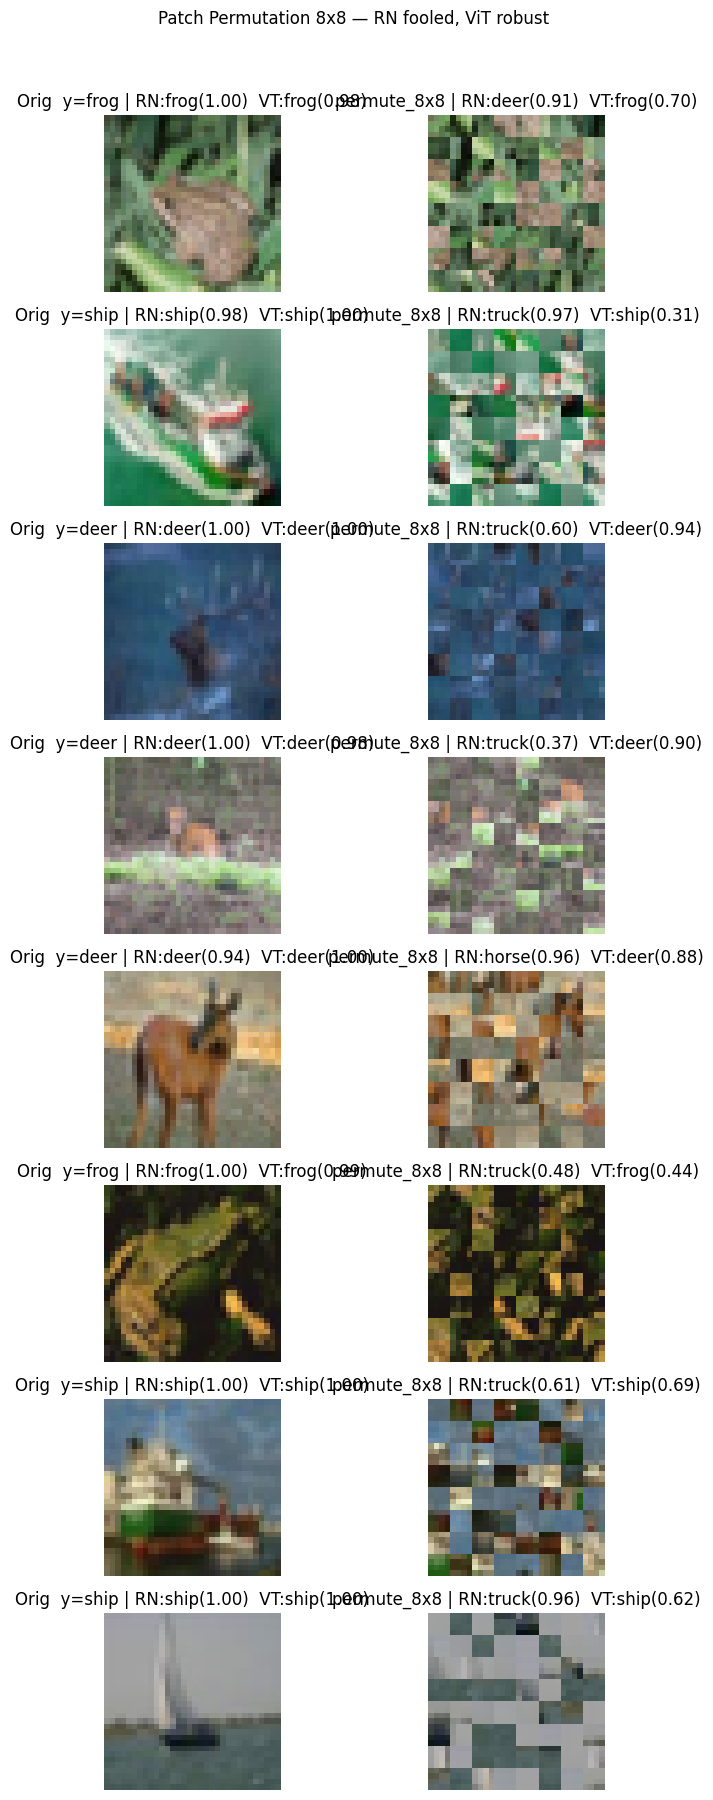

Saved: perm_occ_examples/permute_8x8_examples.png


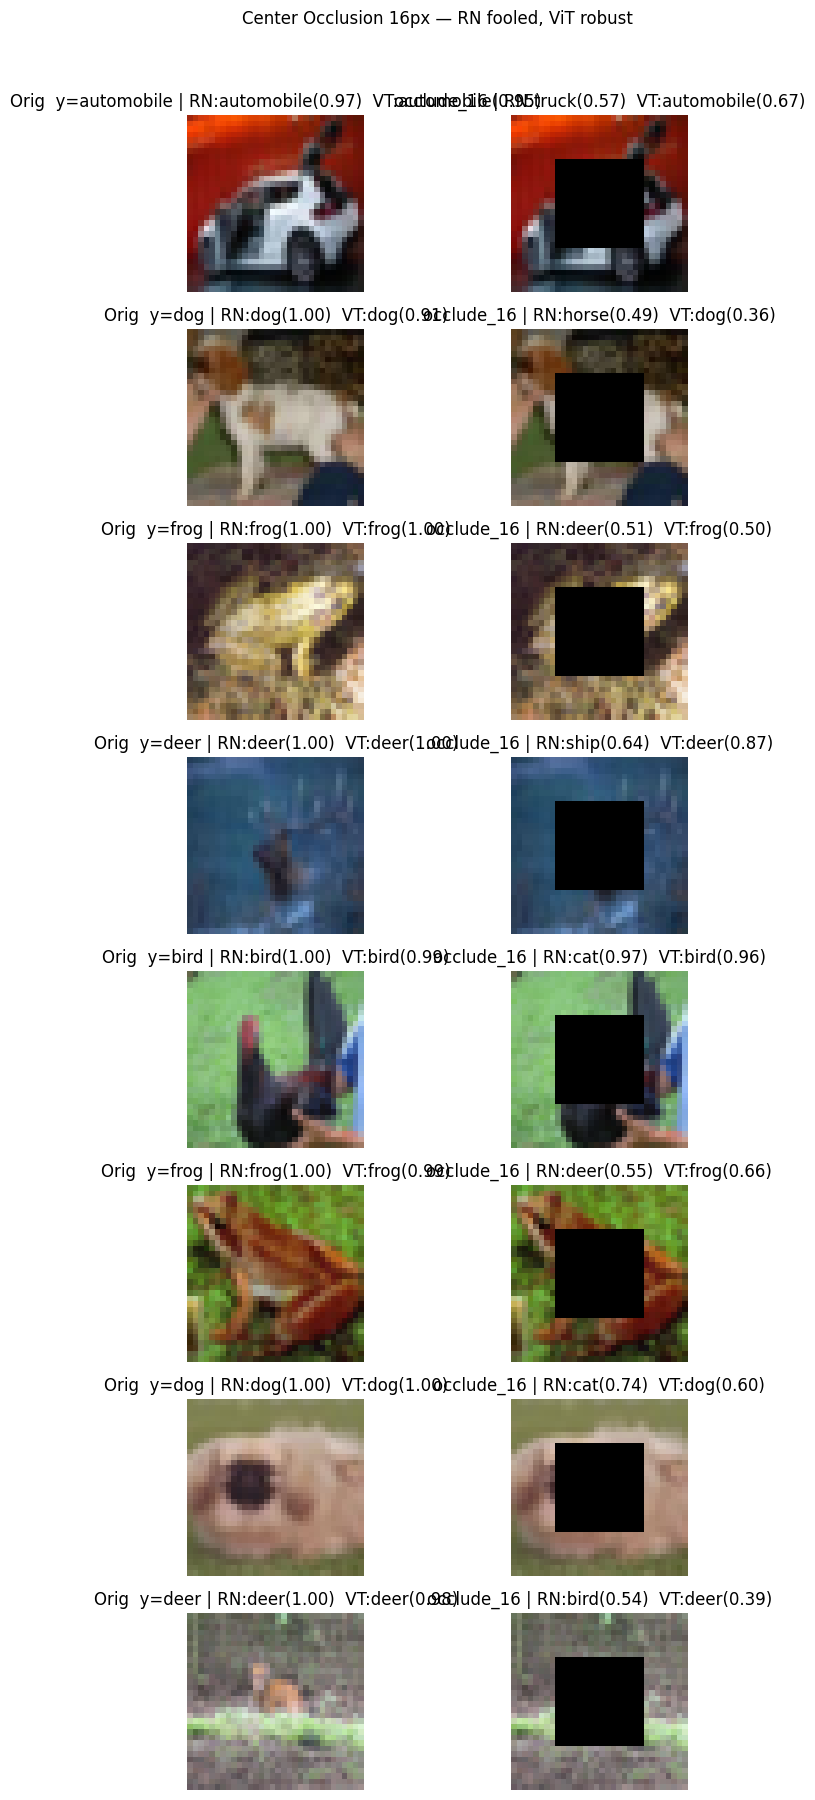

Saved: perm_occ_examples/occlude_16_examples.png


In [40]:
# =========================
# Task 1.6 — Permutation / Occlusion (pre32 pipeline, stratified 1k)
# =========================
import os, csv, math, time, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# -------------------
# Knobs
# -------------------
SUB_PER_CLASS = 100           # 100 per class -> 1000 images; set None for full 10k
BATCH         = 128
NUM_WORKERS   = 2
PERM_GRIDS    = [2, 4, 8]     # patch-permutation grids
OCCL_SIZES    = [8, 16]       # central square occlusions (pixels @32×32)
N_EXAMPLES    = 8             # images to show per example grid

# -------------------
# Models & device (reuse)
# -------------------
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
RN = resnet if 'resnet' in globals() else (resnet_model if 'resnet_model' in globals() else None)
VT = vit    if 'vit'    in globals() else (vit_model    if 'vit_model'    in globals() else None)
assert RN is not None and VT is not None, "Load resnet/vit checkpoints first."
RN.to(DEVICE).eval(); VT.to(DEVICE).eval()

# -------------------
# Data (CIFAR-10)
# -------------------
MEAN, STD = (0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)
MEAN_T = torch.tensor(MEAN).view(1,3,1,1);  STD_T = torch.tensor(STD).view(1,3,1,1)
to_tensor = transforms.ToTensor(); norm = transforms.Normalize(MEAN, STD)
CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

root = "./data"
raw  = datasets.CIFAR10(root, train=False, download=True, transform=None)

# Reuse your 1k subset if already built; otherwise build now (stratified)
if 'test_base' in globals():
    base_dataset = test_base
else:
    if SUB_PER_CLASS is None:
        base_dataset = raw
    else:
        byc = [[] for _ in range(10)]
        for i in range(len(raw)):
            _, y = raw[i]; byc[y].append(i)
        import random; random.seed(42)
        idx = sum([random.sample(byc[c], SUB_PER_CLASS) for c in range(10)], [])
        base_dataset = Subset(raw, idx)

class TV(Dataset):
    def __init__(s, base, tf): s.base, s.tf = base, tf
    def __len__(s): return len(s.base)
    def __getitem__(s,i): x,y = s.base[i]; return s.tf(x), y, i  # keep raw index

base_tf = transforms.Compose([to_tensor, norm])
ldr = DataLoader(TV(base_dataset, base_tf),
                 batch_size=BATCH, shuffle=False,
                 num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

def up224(x):  # (B,3,32,32) -> (B,3,224,224)
    return F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)

# -------------------
# Perturbations (pre32)
# -------------------
def permute_patches_batch(x, grid, perm_idx=None):
    B,C,H,W = x.shape
    assert H==32 and W==32 and 32 % grid == 0
    p = 32 // grid

    # make sure the permutation lives on the same device as x
    if perm_idx is None:
        perm_idx = torch.randperm(grid*grid, device=x.device)
    else:
        perm_idx = perm_idx.to(x.device)

    x = x.view(B, C, grid, p, grid, p).permute(0,2,4,1,3,5).contiguous()  # (B,g,g,C,p,p)
    x = x.view(B, grid*grid, C, p, p)                                     # (B,g^2,C,p,p)
    x = x[:, perm_idx]                                                    # apply permutation
    x = x.view(B, grid, grid, C, p, p).permute(0,3,1,4,2,5).contiguous()
    return x.view(B, C, H, W), perm_idx


def occlude_center(x, size):
    """
    x: (B, C, H, W) normalized tensor at 32×32
    size: occluder side length in pixels
    Fills the central square with normalized-zero ((0-mean)/std).
    """
    B, C, H, W = x.shape
    # bounds-safe box (also handles odd 'size')
    y0 = max(0, (H - size)//2); y1 = min(H, y0 + size)
    x0 = max(0, (W - size)//2); x1 = min(W, x0 + size)

    out = x.clone()
    # expand (1,3,1,1) -> (B, C, size_y, size_x) rather than slicing fill
    fill = ((0.0 - MEAN_T.to(x.device)) / STD_T.to(x.device)).expand(B, C, y1 - y0, x1 - x0)
    out[:, :, y0:y1, x0:x1] = fill
    return out


# -------------------
# Evaluation helpers
# -------------------
@torch.inference_mode()
def run_eval(modify_fn, label, param_key):
    """
    Returns:
      summary dict + long per-sample dicts with preds & confs for both models
    """
    rn_ok = vt_ok = 0; total = 0
    rn_conf_sum = vt_conf_sum = 0.0
    per_sample = []  # list of dicts with idx,y,preds,confs

    for xb, yb, idxs in ldr:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        xb_mod = modify_fn(xb) if modify_fn else xb
        out_rn = RN(xb_mod)                 # RN @32
        out_vt = VT(up224(xb_mod))          # ViT @224

        pr_rn  = out_rn.argmax(1);  pr_vt  = out_vt.argmax(1)
        cf_rn  = out_rn.softmax(1).max(1).values
        cf_vt  = out_vt.softmax(1).max(1).values

        rn_ok += (pr_rn == yb).sum().item()
        vt_ok += (pr_vt == yb).sum().item()
        total += yb.size(0)
        rn_conf_sum += cf_rn.sum().item()
        vt_conf_sum += cf_vt.sum().item()

        for i in range(yb.size(0)):
            per_sample.append({
                "raw_idx": int(idxs[i]),
                "y_true":  int(yb[i].item()),
                f"{param_key}_rn_pred": int(pr_rn[i].item()),
                f"{param_key}_rn_conf": float(cf_rn[i].item()),
                f"{param_key}_vt_pred": int(pr_vt[i].item()),
                f"{param_key}_vt_conf": float(cf_vt[i].item())
            })

    return {
        "label": label,
        "param_key": param_key,
        "ResNet_acc": rn_ok / total,
        "ResNet_conf": rn_conf_sum / total,
        "ViT_acc": vt_ok / total,
        "ViT_conf": vt_conf_sum / total,
        "N": total
    }, per_sample

# -------------------
# Run baseline, permutations, occlusions
# -------------------
results = []
long_rows = []

# baseline
summary_base, long_base = run_eval(lambda x: x, "baseline", "base")
results.append(summary_base); long_rows.extend(long_base)

# permutations (fixed perm per grid)
perm_cache = {}
for g in PERM_GRIDS:
    # capture perm here, reuse in modify_fn via closure
    perm = torch.randperm(g*g, device=DEVICE)
    perm_cache[g] = perm
    def make_perm_fn(grid, perm):
        def fn(x):
            B = x.shape[0]
            # need same perm for the whole batch
            x2, _ = permute_patches_batch(x, grid, perm)
            return x2
        return fn
    summ, long_ps = run_eval(make_perm_fn(g, perm), f"permute_{g}x{g}", f"perm{g}")
    results.append(summ); long_rows.extend(long_ps)

# occlusions
for sz in OCCL_SIZES:
    summ, long_ps = run_eval(lambda x, s=sz: occlude_center(x, s), f"occlude_center_{sz}", f"occ{sz}")
    results.append(summ); long_rows.extend(long_ps)

# -------------------
# Join per-sample to compute deltas wrt baseline
# -------------------
# Build dict from raw_idx -> baseline preds/conf
base_map = {}
for r in long_base:
    base_map[r["raw_idx"]] = {
        "y_true": r["y_true"],
        "base_rn_pred": r["base_rn_pred"], "base_rn_conf": r["base_rn_conf"],
        "base_vt_pred": r["base_vt_pred"], "base_vt_conf": r["base_vt_conf"]
    }

# Merge all rows sharing same raw_idx
from collections import defaultdict
merged = defaultdict(dict)
for r in long_rows:
    rid = r["raw_idx"]
    merged[rid].update(r)
    if rid not in base_map:
        # shouldn't happen, but be safe
        base_map[rid] = {"y_true": r["y_true"], "base_rn_pred": None, "base_rn_conf": None,
                         "base_vt_pred": None, "base_vt_conf": None}

# Materialize long table
import pandas as pd
rows_out = []
for rid, r in merged.items():
    row = {"raw_idx": rid, **base_map[rid]}
    row.update(r)
    rows_out.append(row)
df_long = pd.DataFrame(rows_out)

# -------------------
# Save summaries & long table
# -------------------
os.makedirs("perm_occ_results", exist_ok=True)
sum_path  = "perm_occ_results/task1_6_summary.csv"
long_path = "perm_occ_results/task1_6_per_sample.csv"

with open(sum_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["label","param_key","ResNet_acc","ResNet_conf","ViT_acc","ViT_conf","N"])
    for s in results:
        w.writerow([s["label"], s["param_key"], s["ResNet_acc"], s["ResNet_conf"], s["ViT_acc"], s["ViT_conf"], s["N"]])

df_long.to_csv(long_path, index=False)
print("Saved summary:", sum_path)
print("Saved per-sample:", long_path)

# -------------------
# Print compact summary with deltas vs baseline
# -------------------
base_rn = results[0]["ResNet_acc"]; base_vt = results[0]["ViT_acc"]
print("\n=== Task 1.6 — Accuracy & Confidence (pre32, subset) ===")
for s in results:
    if s["label"] == "baseline":
        print(f"{s['label']:>18} | RN acc {s['ResNet_acc']:.3f} conf {s['ResNet_conf']:.3f} | VT acc {s['ViT_acc']:.3f} conf {s['ViT_conf']:.3f}")
    else:
        d_rn = s["ResNet_acc"] - base_rn
        d_vt = s["ViT_acc"]    - base_vt
        print(f"{s['label']:>18} | RN acc {s['ResNet_acc']:.3f} ({d_rn:+.3f})  | VT acc {s['ViT_acc']:.3f} ({d_vt:+.3f})")

# -------------------
# Example grids (visuals): pick cases showing different behaviors
# -------------------
def denorm_to_np(x):
    # x: (3,32,32) normalized
    x = x.cpu() * STD_T[0] + MEAN_T[0]
    x = x.clamp(0,1).permute(1,2,0).numpy()
    return x

# We need access to raw images again for visualization
# Build a lightweight list of raw PILs and labels for the chosen subset indices
if isinstance(base_dataset, Subset):
    subset_indices = base_dataset.indices
else:
    subset_indices = list(range(len(base_dataset)))

raw_imgs = []
raw_labels = []
for i in subset_indices:
    img, y = raw[i]
    raw_imgs.append(img)
    raw_labels.append(y)

# Helper to render a 2-column grid: original | modified with titles per model
def save_example_grid(examples, title, out_path):
    cols = 2; rows = len(examples)
    plt.figure(figsize=(8, 2.2*rows))
    for r, ex in enumerate(examples):
        # original
        plt.subplot(rows, cols, 2*r+1); plt.imshow(ex["orig"]); plt.axis("off")
        plt.title(f"Orig  y={ex['y']} | RN:{ex['rn0']}({ex['rc0']:.2f})  VT:{ex['vt0']}({ex['vc0']:.2f})")
        # modified
        plt.subplot(rows, cols, 2*r+2); plt.imshow(ex["mod"]); plt.axis("off")
        plt.title(f"{ex['cond']} | RN:{ex['rn1']}({ex['rc1']:.2f})  VT:{ex['vt1']}({ex['vc1']:.2f})")
    plt.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.show()
    print("Saved:", out_path)

# Build a quick inference util on tensors
@torch.inference_mode()
def infer_pair(x32, modify_fn):
    x32 = x32.to(DEVICE)[None]
    out0_rn = RN(x32); out0_vt = VT(up224(x32))
    p0_rn = out0_rn.argmax(1).item(); p0_vt = out0_vt.argmax(1).item()
    c0_rn = out0_rn.softmax(1).max(1).values.item()
    c0_vt = out0_vt.softmax(1).max(1).values.item()

    xm = modify_fn(x32)
    out1_rn = RN(xm); out1_vt = VT(up224(xm))
    p1_rn = out1_rn.argmax(1).item(); p1_vt = out1_vt.argmax(1).item()
    c1_rn = out1_rn.softmax(1).max(1).values.item()
    c1_vt = out1_vt.softmax(1).max(1).values.item()
    return (p0_rn,c0_rn,p0_vt,c0_vt), (p1_rn,c1_rn,p1_vt,c1_vt)

# Choose examples for two conditions:
# 1) permute_8x8: find cases where RN changes/errs while VT holds
# 2) occlude_center_16: same idea
os.makedirs("perm_occ_examples", exist_ok=True)

def pick_examples_for(cond_key, modify_fn, want_flip_rn=True, max_n=N_EXAMPLES):
    exs = []
    count = 0
    for local_i, raw_i in enumerate(subset_indices):
        # get normalized tensor for this one item (CPU)
        x0, y, _ = base_tf(raw_imgs[local_i]), raw_labels[local_i], None

        # run the paired inference (this already moves tensors to DEVICE inside)
        (rn0, rc0, vt0, vc0), (rn1, rc1, vt1, vc1) = infer_pair(x0, modify_fn)

        # selection rule: both correct on clean; after perturbation RN flips & ViT holds (or the opposite)
        cond1 = (rn0 == y) and (vt0 == y)
        if want_flip_rn:
            cond2 = (rn1 != y) and (vt1 == y)   # RN fooled, ViT robust
        else:
            cond2 = (vt1 != y) and (rn1 == y)   # ViT fooled, RN robust

        if cond1 and cond2:
            # --- build the modified image for DISPLAY safely across devices ---
            xb_cpu = base_tf(raw_imgs[local_i])                        # (3,32,32) on CPU
            xm_dev = modify_fn(xb_cpu.unsqueeze(0).to(DEVICE))         # (1,3,32,32) on DEVICE
            xm_cpu = xm_dev.detach().cpu()[0]                          # back to CPU for PIL/np

            exs.append({
                "orig": np.array(raw_imgs[local_i]),
                "mod":  np.array(transforms.ToPILImage()(denorm_to_np(xm_cpu))),
                "y": CLASSES[y],
                "rn0": CLASSES[rn0], "rc0": rc0, "vt0": CLASSES[vt0], "vc0": vc0,
                "rn1": CLASSES[rn1], "rc1": rc1, "vt1": CLASSES[vt1], "vc1": vc1,
                "cond": cond_key
            })
            count += 1
            if count >= max_n:
                break
    return exs


# Make modify_fns for the chosen conditions
perm8 = torch.randperm(8*8, device=DEVICE)
def modify_perm8(x):  # x: (1,3,32,32)
    return permute_patches_batch(x, 8, perm8)[0]

def modify_occ16(x):  # x: (1,3,32,32)
    return occlude_center(x, 16)

# Build and save example grids
ex_perm = pick_examples_for("permute_8x8", modify_perm8, want_flip_rn=True, max_n=N_EXAMPLES)
if len(ex_perm)>0:
    save_example_grid(ex_perm, "Patch Permutation 8x8 — RN fooled, ViT robust", "perm_occ_examples/permute_8x8_examples.png")
else:
    print("Note: Couldn't find RN-flip/VT-stable examples for permute_8x8 with current subset.")

ex_occ = pick_examples_for("occlude_16", modify_occ16, want_flip_rn=True, max_n=N_EXAMPLES)
if len(ex_occ)>0:
    save_example_grid(ex_occ, "Center Occlusion 16px — RN fooled, ViT robust", "perm_occ_examples/occlude_16_examples.png")
else:
    print("Note: Couldn't find RN-flip/VT-stable examples for occlude_16 with current subset.")


In [41]:
import csv
path = "perm_occ_results/task1_6_summary.csv"
rows = list(csv.DictReader(open(path)))
base = next(r for r in rows if r["label"]=="baseline")
br, bv = float(base["ResNet_conf"]), float(base["ViT_conf"])
for r in rows:
    dr = float(r["ResNet_conf"]) - br
    dv = float(r["ViT_conf"])    - bv
    print(f"{r['label']:>18} | Δconf RN {dr:+.3f} | Δconf ViT {dv:+.3f}")


          baseline | Δconf RN +0.000 | Δconf ViT +0.000
       permute_2x2 | Δconf RN -0.173 | Δconf ViT -0.205
       permute_4x4 | Δconf RN -0.195 | Δconf ViT -0.246
       permute_8x8 | Δconf RN -0.193 | Δconf ViT -0.219
  occlude_center_8 | Δconf RN -0.076 | Δconf ViT -0.060
 occlude_center_16 | Δconf RN -0.171 | Δconf ViT -0.232


## 7: Feature Representation Analysis:
To delve into how each model represents the data, perform a visualization of the feature space. Take a subset of images (maybe include some stylized or OOD examples
as well) and extract the penultimate layer features (the embedding before the final classification layer) from
the ResNet and ViT. Apply a dimensionality reduction (e.g. t-SNE or PCA) to each model’s embeddings
separately and plot them. Color-code the points by class (and perhaps by whether the image was normal or
stylized, etc.). Compare the plots: does one model separate the classes more distinctly in feature space? Are
stylized images embedding closer to their original class in one model vs the other? For example, you might
find the ViT’s representation clusters images by their true object category more clearly even across style
changes, whereas the CNN’s clusters might mix up classes that share textural similarities. Such observations
can provide evidence of the different semantic focus of their features. Include these plots in your report and
interpret them

RN feats: (20000, 2048) | ViT feats: (20000, 384) | N: 20000
Saved: repr_analysis/emb2d_resnet.csv & emb2d_vit.csv


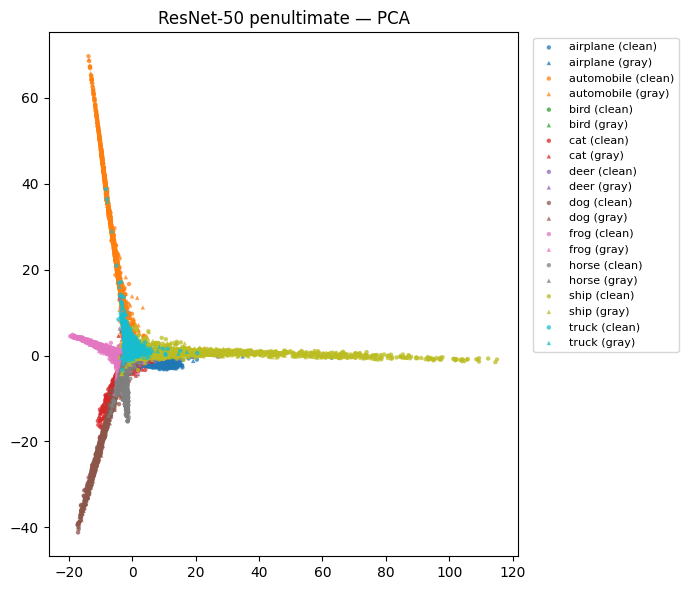

Saved: repr_analysis/plot_resnet.png


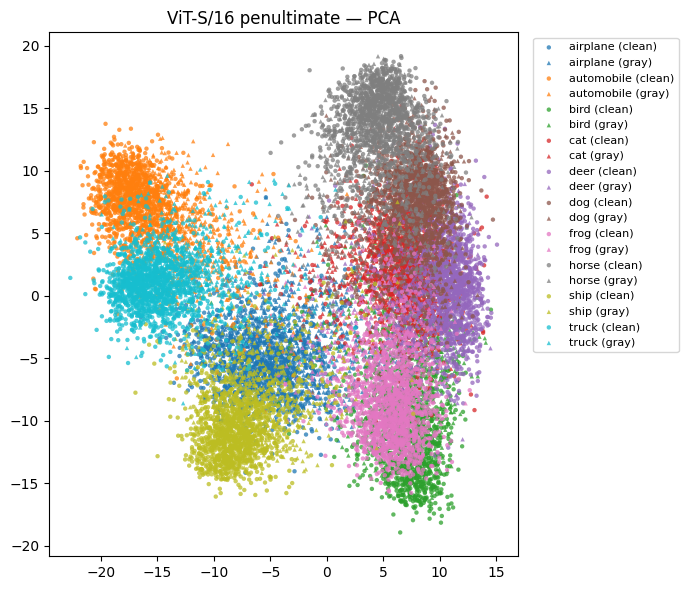

Saved: repr_analysis/plot_vit.png


In [42]:
# =========================
# Task 1.7 — Feature Representation Analysis (ResNet-50 vs ViT-S/16)
# =========================
import os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- toggles ---
SUB_PER_CLASS = 100          # 100 per class => 1k (set None for full 10k)
BATCH = 128
NUM_WORKERS = 2
USE_TSNE = False             # True = t-SNE (slower); False = PCA (fast)
ADD_STYLIZED = False         # set True if you have a stylized set loader below

# --- models & device (reuse) ---
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
RN = resnet if 'resnet' in globals() else (resnet_model if 'resnet_model' in globals() else None)
VT = vit    if 'vit'    in globals() else (vit_model    if 'vit_model'    in globals() else None)
assert RN is not None and VT is not None, "Load resnet/vit checkpoints first."
RN.to(DEVICE).eval(); VT.to(DEVICE).eval()

# --- data ---
MEAN, STD = (0.4914,0.4822,0.4465), (0.2470,0.2435,0.2616)
CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
to_tensor = transforms.ToTensor()
norm = transforms.Normalize(MEAN, STD)

root = "./data"
raw = datasets.CIFAR10(root, train=False, download=True, transform=None)

# stratified 1k subset (reuse existing test_base if present)
if 'test_base' in globals():
    base = test_base
else:
    if SUB_PER_CLASS is None:
        base = raw
    else:
        byc=[[] for _ in range(10)]
        for i in range(len(raw)):
            _,y = raw[i]; byc[y].append(i)
        import random; random.seed(42)
        idx = sum([random.sample(byc[c], SUB_PER_CLASS) for c in range(10)], [])
        base = Subset(raw, idx)

# domains: clean + grayscale (+ optional stylized)
class TV(Dataset):
    def __init__(s, base, tf, domain): s.base, s.tf, s.domain = base, tf, domain
    def __len__(s): return len(s.base)
    def __getitem__(s,i): x,y = s.base[i]; return s.tf(x), y, s.domain

gray_tf = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                              to_tensor, norm])
clean_tf32 = transforms.Compose([to_tensor, norm])

datasets_by_domain = [
    TV(base, clean_tf32, "clean"),
    TV(base, gray_tf,    "gray"),
]

# Optional: stylized. If you have a stylized dataset function or cache, plug it here.
# Example stub (set ADD_STYLIZED=True and implement stylize_fn for your setup):
if ADD_STYLIZED:
    def stylize_fn(img):  # TODO: replace with your FDA/style-transfer if available
        return transforms.ColorJitter(0.4,0.4,0.4,0.2)(img)
    stylized_tf = transforms.Compose([stylize_fn, to_tensor, norm])
    datasets_by_domain.append(TV(base, stylized_tf, "stylized"))

# build one combined loader (we’ll keep domain labels alongside)
class Cat(Dataset):
    def __init__(s, parts):
        s.parts = parts
        s.lens = [len(p) for p in parts]
        s.cum = np.cumsum([0]+s.lens)
    def __len__(s): return sum(s.lens)
    def __getitem__(s, i):
        k = np.searchsorted(s.cum, i, side="right")-1
        return s.parts[k][i - s.cum[k]]

combo = Cat(datasets_by_domain)
loader = DataLoader(combo, batch_size=BATCH, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

# --- penultimate feature extractors ---
# ResNet-50: grab the tensor before fc (after avgpool -> flatten)
class RNWrapper(nn.Module):
    def __init__(s, rn):
        super().__init__(); s.rn = rn
        s.feat = None
        # hook at avgpool output (shape B,2048,1,1)
        def hook(module, inp, out):
            s.feat = out.view(out.size(0), -1).detach()
        s.rn.avgpool.register_forward_hook(hook)
    def forward(s, x):
        _ = s.rn(x)        # run forward to populate s.feat
        return s.feat

RN_FE = RNWrapper(RN).to(DEVICE).eval()

# ViT-S/16 (timm): use forward_features / pre_logits to get CLS embedding
def vit_penultimate(model, x):
    f = model.forward_features(x)
    if isinstance(f, dict):
        # try common keys
        for k in ["x_norm_clstoken","pooled","cls_token","feat"]:
            if k in f:
                f = f[k]; break
        if isinstance(f, dict):
            f = next(iter(f.values()))
    if f.dim() == 3:       # (B, tokens, dim) -> take CLS token
        f = f[:,0]
    # if representation layer exists, apply pre_logits (often Identity for vit_small)
    if hasattr(model, "pre_logits"):
        f = model.pre_logits(f)
    return f

# --- extract features ---
def up224(x): return F.interpolate(x, size=(224,224), mode="bilinear", align_corners=False)

emb_rn, y_rn, d_rn = [], [], []
emb_vt, y_vt, d_vt = [], [], []

with torch.inference_mode():
    for xb, yb, db in loader:
        xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE)
        # ResNet
        fr = RN_FE(xb)                                 # (B,2048)
        emb_rn.append(fr.cpu()); y_rn.append(yb.cpu()); d_rn += list(db)
        # ViT (resize to 224)
        fv = vit_penultimate(VT, up224(xb))            # (B,384) typically
        emb_vt.append(fv.detach().cpu()); y_vt.append(yb.cpu()); d_vt += list(db)

emb_rn = torch.cat(emb_rn).numpy()
emb_vt = torch.cat(emb_vt).numpy()
labels  = torch.cat(y_rn).numpy()        # same order for both due to single loader
domains = np.array(d_rn)

print("RN feats:", emb_rn.shape, "| ViT feats:", emb_vt.shape, "| N:", len(labels))

# --- dimensionality reduction (separately per model) ---
def reduce_2d(X, use_tsne=False, seed=42):
    if use_tsne:
        from sklearn.manifold import TSNE
        return TSNE(n_components=2, perplexity=30, learning_rate="auto",
                    init="pca", n_iter=1000, random_state=seed).fit_transform(X)
    else:
        from sklearn.decomposition import PCA
        return PCA(n_components=2, random_state=seed).fit_transform(X)

Z_rn = reduce_2d(emb_rn, USE_TSNE)
Z_vt = reduce_2d(emb_vt, USE_TSNE)

# --- save CSVs for report ---
import pandas as pd, os
os.makedirs("repr_analysis", exist_ok=True)
df_rn = pd.DataFrame({"x":Z_rn[:,0], "y":Z_rn[:,1], "label":labels, "class":[CLASSES[i] for i in labels], "domain":domains, "model":"ResNet-50"})
df_vt = pd.DataFrame({"x":Z_vt[:,0], "y":Z_vt[:,1], "label":labels, "class":[CLASSES[i] for i in labels], "domain":domains, "model":"ViT-S/16"})
df_rn.to_csv("repr_analysis/emb2d_resnet.csv", index=False)
df_vt.to_csv("repr_analysis/emb2d_vit.csv", index=False)
print("Saved: repr_analysis/emb2d_resnet.csv & emb2d_vit.csv")

# --- plotting helpers ---
COLORS = np.array([[31,119,180],[255,127,14],[44,160,44],[214,39,40],[148,103,189],
                   [140,86,75],[227,119,194],[127,127,127],[188,189,34],[23,190,207]])/255.0
MARK  = {"clean":"o","gray":"^","stylized":"s"}

def plot_embed(Z, labels, domains, title, out_png):
    plt.figure(figsize=(7,6))
    for c in range(10):
        mask_c = (labels==c)
        for dom, m in MARK.items():
            mask = mask_c & (domains==dom)
            if mask.sum()==0: continue
            plt.scatter(Z[mask,0], Z[mask,1], s=10, marker=m, c=COLORS[c][None,:], label=f"{CLASSES[c]} ({dom})", alpha=0.75, edgecolors='none')
    # one legend per class only (avoid duplicates)
    handles, labels_ = plt.gca().get_legend_handles_labels()
    # collapse duplicates by text
    seen=set(); uniq_h, uniq_l = [], []
    for h,l in zip(handles, labels_):
        if l not in seen:
            seen.add(l); uniq_h.append(h); uniq_l.append(l)
    plt.legend(uniq_h, uniq_l, bbox_to_anchor=(1.02,1.0), loc="upper left", fontsize=8, ncol=1)
    plt.title(title); plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.show()
    print("Saved:", out_png)

plot_embed(Z_rn, labels, domains, f"ResNet-50 penultimate — {'t-SNE' if USE_TSNE else 'PCA'}", "repr_analysis/plot_resnet.png")
plot_embed(Z_vt, labels, domains, f"ViT-S/16 penultimate — {'t-SNE' if USE_TSNE else 'PCA'}", "repr_analysis/plot_vit.png")


In [43]:
# ===== Task 1.7 metrics: silhouette + centroid drift (clean↔gray/ stylized) =====
import os, numpy as np, pandas as pd
from sklearn.metrics import silhouette_score

os.makedirs("repr_analysis", exist_ok=True)

# --- fetch 2D embeddings & meta (load if not in memory) ---
def load_2d_csv(path):
    df = pd.read_csv(path)
    Z = df[["x","y"]].values
    labs = df["label"].values.astype(int)
    doms = df["domain"].values
    return Z, labs, doms

if 'Z_rn' not in globals() or 'Z_vt' not in globals() or 'labels' not in globals() or 'domains' not in globals():
    Z_rn, labels, domains = load_2d_csv("repr_analysis/emb2d_resnet.csv")
    Z_vt, _, _             = load_2d_csv("repr_analysis/emb2d_vit.csv")

# --- silhouette (2D PCA) ---
sil2_rn = silhouette_score(Z_rn, labels)
sil2_vt = silhouette_score(Z_vt, labels)

# --- optional: silhouette on penultimate if available ---
silp_rn = None; silp_vt = None
try:
    if 'emb_rn' in globals() and isinstance(emb_rn, np.ndarray):
        silp_rn = silhouette_score(emb_rn, labels)
    if 'emb_vt' in globals() and isinstance(emb_vt, np.ndarray):
        silp_vt = silhouette_score(emb_vt, labels)
except Exception as e:
    print("[Note] Silhouette on penultimate failed:", e)

# --- centroid drift helper (works on any 2D embedding) ---
def centroid(v):
    return v.mean(axis=0) if len(v) else np.array([np.nan, np.nan])

def per_class_drift(Z, labels, domains, classes, dom_from="clean", dom_to="gray"):
    rows = []
    for c in range(len(classes)):
        m_clean = (labels==c) & (domains==dom_from)
        m_to    = (labels==c) & (domains==dom_to)
        if m_clean.sum()==0 or m_to.sum()==0:
            rows.append([classes[c], dom_to, np.nan, np.nan, int(m_clean.sum()), int(m_to.sum())])
            continue
        mu_clean = centroid(Z[m_clean])
        mu_to    = centroid(Z[m_to])
        drift = float(np.linalg.norm(mu_to - mu_clean))
        # within-class spread on clean (mean distance to centroid)
        spread = float(np.linalg.norm(Z[m_clean] - mu_clean, axis=1).mean())
        norm_drift = drift / (spread + 1e-8)
        rows.append([classes[c], dom_to, drift, norm_drift, int(m_clean.sum()), int(m_to.sum())])
    return pd.DataFrame(rows, columns=["class","target_domain","centroid_drift","normalized_drift","n_clean","n_target"])

# derive CLASSES if missing (should be defined already)
if 'CLASSES' not in globals():
    CLASSES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# ensure domains as np.array(str)
domains = np.asarray(domains)

# compute drifts on PCA-2 for gray; also stylized if present
df_dr_rn_g = per_class_drift(Z_rn, labels, domains, CLASSES, "clean", "gray")
df_dr_vt_g = per_class_drift(Z_vt, labels, domains, CLASSES, "clean", "gray")

has_styl = np.any(domains == "stylized")
if has_styl:
    df_dr_rn_s = per_class_drift(Z_rn, labels, domains, CLASSES, "clean", "stylized")
    df_dr_vt_s = per_class_drift(Z_vt, labels, domains, CLASSES, "clean", "stylized")

# save CSV
out_rows = []
for i,cls in enumerate(CLASSES):
    gr = df_dr_rn_g.iloc[i]; gv = df_dr_vt_g.iloc[i]
    row = {
        "class": cls,
        "RN_gray_drift": gr["centroid_drift"], "RN_gray_norm": gr["normalized_drift"],
        "VT_gray_drift": gv["centroid_drift"], "VT_gray_norm": gv["normalized_drift"]
    }
    if has_styl:
        sr = df_dr_rn_s.iloc[i]; sv = df_dr_vt_s.iloc[i]
        row.update({
            "RN_styl_drift": sr["centroid_drift"], "RN_styl_norm": sr["normalized_drift"],
            "VT_styl_drift": sv["centroid_drift"], "VT_styl_norm": sv["normalized_drift"]
        })
    out_rows.append(row)

df_out = pd.DataFrame(out_rows)
csv_path = "repr_analysis/centroid_drift.csv"
df_out.to_csv(csv_path, index=False)

# print summary
def summarize(df, prefix):
    m = df.filter(like=prefix).mean(numeric_only=True)
    return ", ".join([f"{k}={v:.3f}" for k,v in m.items()])

print("\n=== Feature-space separation ===")
print(f"Silhouette (PCA-2)   -> RN: {sil2_rn:.3f} | ViT: {sil2_vt:.3f}")
if silp_rn is not None and silp_vt is not None:
    print(f"Silhouette (penult.) -> RN: {silp_rn:.3f} | ViT: {silp_vt:.3f}")

print("\n=== Centroid drift (clean → gray) on PCA-2 ===")
print("RN (mean):", summarize(df_out, "RN_gray"))
print("VT (mean):", summarize(df_out, "VT_gray"))
if has_styl:
    print("\n=== Centroid drift (clean → stylized) on PCA-2 ===")
    print("RN (mean):", summarize(df_out, "RN_styl"))
    print("VT (mean):", summarize(df_out, "VT_styl"))

print(f"\nSaved per-class drift CSV → {csv_path}")



=== Feature-space separation ===
Silhouette (PCA-2)   -> RN: -0.013 | ViT: 0.137
Silhouette (penult.) -> RN: 0.066 | ViT: 0.327

=== Centroid drift (clean → gray) on PCA-2 ===
RN (mean): RN_gray_drift=2.949, RN_gray_norm=0.396
VT (mean): VT_gray_drift=2.396, VT_gray_norm=0.676

Saved per-class drift CSV → repr_analysis/centroid_drift.csv


## 8: Domain Generalization Test on PACS:
Test the models on a simple domain shift using the PACS dataset.
For example, fine-tune both models on three domains of PACS and evaluate on the remaining domain (take
Sketch as test domain as this one is challenging). Measure which model’s accuracy drops more. We anticipate
that the ViT (with its shape bias and global context) may handle the domain shift better than the CNN. For
instance, CNNs often struggle with sketches (line drawings with no texture), whereas a shape-biased model
should fare better. Report any findings – even if both fail, it’s insightful to note the failure modes: did the
CNN predict based on background or texture-like cues that weren’t there? Did the ViT manage to pick the
correct or a semantically close class?.

In [44]:
# =========================
# Task 1.8 — PACS Domain Generalization (train on 3, test on Sketch)
# =========================
import os, math, time, random, csv, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import datasets, transforms, models
import timm
from collections import defaultdict

# ---------- CONFIG ----------
PACS_ROOT = "/content/PACS"   # <- change if needed; expects /{photo,art_painting,cartoon,sketch}/{class}/img.jpg
TRAIN_DOMAINS = ["photo","art_painting","cartoon"]
TEST_DOMAIN   = "sketch"      # challenging domain
NUM_CLASSES   = 7             # PACS has 7 categories
SEED          = 42

# speed/robustness knobs
LIMIT_PER_CLASS = None        # e.g., 200 to quick-run; None = use all
VAL_SPLIT = 0.1               # validation split inside the 3 train domains
EPOCHS    = 10                # bump to 20+ for stronger results
BATCH_RN  = 64
BATCH_VIT = 64
LR        = 5e-4
WD        = 0.05
PATIENCE  = 5                 # early stop

DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

IMNET_MEAN = (0.485,0.456,0.406)
IMNET_STD  = (0.229,0.224,0.225)

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

# ---------- DATA HELPERS ----------
def domain_folder(root, name):
    # PACS names vary in capitalization sometimes; be tolerant
    for cand in [name, name.lower(), name.upper(), name.replace("_"," "), name.replace("_","-")]:
        p = Path(root)/cand
        if p.is_dir(): return str(p)
    raise FileNotFoundError(f"Domain '{name}' not found under {root}")

def limit_per_class_indices(ds: datasets.ImageFolder, limit=None, seed=SEED):
    if not limit: return list(range(len(ds)))
    byc = defaultdict(list)
    for i,(_,y) in enumerate(ds.samples):
        byc[y].append(i)
    rng = random.Random(seed)
    idx = []
    for y,arr in byc.items():
        rng.shuffle(arr)
        idx += arr[:limit]
    return sorted(idx)

def build_domain_splits(root, train_domains, test_domain, limit_per_class=None, val_split=0.1):
    # load per-domain datasets
    train_parts, val_parts = [], []
    class_names_ref = None

    for d in train_domains:
        folder = domain_folder(root, d)
        full = datasets.ImageFolder(folder, transform=train_tf)
        # sanity: consistent class names
        if class_names_ref is None: class_names_ref = full.classes
        else:
            assert full.classes == class_names_ref, "Class folders differ across domains."

        # limit per class if requested (for speed)
        idx = limit_per_class_indices(full, limit_per_class)
        full = Subset(full, idx)

        # stratified split per domain
        # build y array
        ys = []
        if isinstance(full, Subset):
            ys = [full.dataset.samples[i][1] for i in full.indices]
        else:
            ys = [y for _,y in full.samples]
        byc = defaultdict(list)
        for i,y in enumerate(ys): byc[y].append(i)
        rng = random.Random(SEED)
        tr_idx, va_idx = [], []
        for y, arr in byc.items():
            rng.shuffle(arr)
            k = max(1, int((1.0 - val_split)*len(arr)))
            tr_idx += arr[:k]; va_idx += arr[k:]
        train_parts.append(Subset(full, tr_idx))
        # switch val transform
        val_domain = datasets.ImageFolder(folder, transform=eval_tf)
        if limit_per_class:
            val_domain = Subset(val_domain, [full.indices[i] for i in va_idx])
        else:
            # map original indices to val subset
            all_idx = list(range(len(val_domain)))
            # remap per-domain by class with same split sizes
            # (approximate: we pick the tail portion)
            # better: re-run the stratified split directly on val_domain
            byc2 = defaultdict(list)
            for i,(_,y) in enumerate(val_domain.samples): byc2[y].append(i)
            va_idx2=[]
            for y,arr in byc2.items():
                k = int(val_split*len(arr))
                va_idx2 += arr[-k:] if k>0 else []
            val_domain = Subset(val_domain, va_idx2)
        val_parts.append(val_domain)

    # combine train and val from 3 domains
    train_ds = ConcatDataset(train_parts)
    val_ds   = ConcatDataset(val_parts)

    # test = held-out domain
    test_folder = domain_folder(root, test_domain)
    test_ds = datasets.ImageFolder(test_folder, transform=eval_tf)
    return train_ds, val_ds, test_ds, class_names_ref

train_ds, val_ds, test_ds, CLASS_NAMES = build_domain_splits(
    PACS_ROOT, TRAIN_DOMAINS, TEST_DOMAIN, limit_per_class=LIMIT_PER_CLASS, val_split=VAL_SPLIT
)

train_loader = DataLoader(train_ds, batch_size=BATCH_RN, shuffle=True,  num_workers=2, pin_memory=(DEVICE=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_RN, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))
print(f"Train imgs: {len(train_ds)} | Val imgs: {len(val_ds)} | Sketch test imgs: {len(test_ds)} | Classes: {CLASS_NAMES}")

# ---------- MODELS ----------
def build_resnet50_pacs():
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    return m

def build_vit_s16_pacs():
    m = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
    return m

# ---------- TRAIN / EVAL ----------
class AverageMeter:
    def __init__(self): self.n=0; self.v=0.0
    def add(self, x, k): self.v += float(x)*k; self.n += k
    @property
    def avg(self): return self.v/max(1,self.n)

@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    model.eval(); tot=0; ok=0; loss_meter=AverageMeter()
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss_meter.add(loss.item(), y.size(0))
        ok += (logits.argmax(1)==y).sum().item(); tot += y.size(0)
    return loss_meter.avg, ok/tot

def fit_model(make_model, tag, batch_size, epochs=EPOCHS):
    model = make_model().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
    best_val = -1.0; best_path = f"pacs_{tag}_best.pth"
    patience = PATIENCE; bad=0
    # rebuild loaders if batch differs
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=(DEVICE=="cuda"))
    val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))
    test_ld  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))

    for ep in range(1, epochs+1):
        model.train(); tot=0; ok=0; loss_meter=AverageMeter(); t0=time.time()
        for x,y in train_ld:
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            loss_meter.add(loss.item(), y.size(0))
            ok += (logits.argmax(1)==y).sum().item(); tot += y.size(0)
        tr_acc = ok/tot
        val_loss, val_acc = evaluate(model, val_ld)
        print(f"[{tag}] Ep{ep:02d} | train {loss_meter.avg:.3f}/{tr_acc:.3f} | val {val_loss:.3f}/{val_acc:.3f} | {time.time()-t0:.1f}s")

        if val_acc > best_val:
            best_val = val_acc; bad=0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            if bad >= patience:
                print(f"[{tag}] Early stop at ep{ep}, best val {best_val:.3f}")
                break

    # load best and test
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    test_loss, test_acc = evaluate(model, test_ld)
    print(f"[{tag}] Best on val -> Sketch test acc: {test_acc:.4f}")
    return {"tag": tag, "best_val_acc": best_val, "sketch_acc": test_acc, "ckpt": best_path}

# ---------- RUN ----------
res = []
res.append(fit_model(build_resnet50_pacs, "resnet50_pacs", BATCH_RN))
res.append(fit_model(build_vit_s16_pacs,  "vit_s16_pacs",  BATCH_VIT))

# summarize + save
os.makedirs("pacs_results", exist_ok=True)
with open("pacs_results/summary.csv","w",newline="") as f:
    w = csv.writer(f); w.writerow(["model","val_acc_seen","sketch_acc","drop"])
    for r in res:
        drop = r["best_val_acc"] - r["sketch_acc"]
        w.writerow([r["tag"], f"{r['best_val_acc']:.4f}", f"{r['sketch_acc']:.4f}", f"{drop:.4f}"])
print("Saved: pacs_results/summary.csv")

# ---------- Extra: per-class accuracy + confusion on Sketch ----------
@torch.no_grad()
def per_class_metrics(model, loader):
    model.eval()
    n = NUM_CLASSES
    cm = torch.zeros(n,n, dtype=torch.int64)
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        p = model(x).argmax(1)
        for t,pr in zip(y.cpu(), p.cpu()):
            cm[t,pr] += 1
    acc_per = cm.diag() / cm.sum(1).clamp_min(1)
    return cm, acc_per

# load best checkpoints and compute sketch metrics
rn = build_resnet50_pacs().to(DEVICE); rn.load_state_dict(torch.load("pacs_resnet50_pacs_best.pth", map_location=DEVICE))
vt = build_vit_s16_pacs().to(DEVICE); vt.load_state_dict(torch.load("pacs_vit_s16_pacs_best.pth", map_location=DEVICE))
sk_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=(DEVICE=="cuda"))

cm_rn, acc_rn = per_class_metrics(rn, sk_loader)
cm_vt, acc_vt = per_class_metrics(vt, sk_loader)

print("\nPer-class Sketch accuracy (ResNet):")
for i,c in enumerate(CLASS_NAMES): print(f"{c:>10}: {acc_rn[i]:.3f}")
print("\nPer-class Sketch accuracy (ViT):")
for i,c in enumerate(CLASS_NAMES): print(f"{c:>10}: {acc_vt[i]:.3f}")

# small confusion matrix peek
def top_confusions(cm, classes, k=5):
    # returns top off-diagonal counts
    c = cm.clone(); c.fill_diagonal_(0)
    flat = torch.nonzero(c, as_tuple=False)
    entries = [(classes[i], classes[j], int(c[i,j])) for i,j in flat]
    entries.sort(key=lambda t: t[2], reverse=True)
    return entries[:k]

print("\nTop confusions (RN):", top_confusions(cm_rn, CLASS_NAMES))
print("Top confusions (ViT):", top_confusions(cm_vt, CLASS_NAMES))


FileNotFoundError: Domain 'photo' not found under /content/PACS